# Import modules. Run once

In [2]:
%matplotlib

# import system modules
import sys
import os.path
import matplotlib.pyplot as plt   
from IPython.display import clear_output
import numpy as np
import json
import visa
import time
from scipy import optimize
from math import pi

# Add path
#sys.path.remove(r'\\shared.ad.syr.edu\AS-Filer\PHY-PRL-labshare\Programs\python\Drivers')
#sys.path.append(r'Z:\User\Jaseung\programs\pythonCode\Instrument Driver') # path added
sys.path.append('..\Instrument Driver') # path added

sys.path.append('..\Helper') # path added

# custom modules
import myplots_py3, myutils # Jaseung's custom modules


Using matplotlib backend: Qt5Agg


In [2]:
sys.path

['Z:\\User\\Jaseung\\programs\\pythonCode\\PNA',
 'C:\\Users\\labuser\\Anaconda3\\python37.zip',
 'C:\\Users\\labuser\\Anaconda3\\DLLs',
 'C:\\Users\\labuser\\Anaconda3\\lib',
 'C:\\Users\\labuser\\Anaconda3',
 '',
 'C:\\Users\\labuser\\Anaconda3\\lib\\site-packages',
 'C:\\Users\\labuser\\Anaconda3\\lib\\site-packages\\win32',
 'C:\\Users\\labuser\\Anaconda3\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\labuser\\Anaconda3\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\labuser\\Anaconda3\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\labuser\\.ipython',
 '..\\Instrument Driver',
 '..\\Helper']

# Set up devices to use. Modify and run once.

In [3]:
# instrument drivers
import SIM
import AgilentN5230A
import LSCI332S
import HittiteHMC
import AgilentMXG
import SynthHD
import Agilent33250A
import KeysightP9372A
# import Lakeshore218
# import SR830 #For Lock-in driver!

# instrument instances. Make device objects.
# pna = AgilentN5230A.AgilentN5230A(16)
# pna = KeysightP9372A.KeysightP9372A('USB0::0x0957::0x179B::MY51361453::0::INSTR')
pna = KeysightP9372A.KeysightP9372A('PXI10::0-0.0::INSTR')
pna.connect()
# sim_p = SIM.SIM(15, channel = 3)
sim_p1 = SIM.SIM('COM10', channel = 1)
sim_p2 = SIM.SIM('COM10', channel = 2)
sim_s = SIM.SIM('COM10',channel = 3)
# sim_c = SIM.SIM(18, channel = 3)
# sim_f = SIM.SIM(18, channel = 1)
# sim_c = SIM.SIM(18, channel = 2)
# sim_f2 = SIM.SIM(18, channel = 3)
# sim_p2 = SIM.SIM(15, channel = 1)
# sim_p1 = SIM.SIM(15, channel = 3)
# sim_s = Agilent33250A.Agilent33250A(13)
#sim_glb = SIM.SIM(15, channel = 3) # ADR2
# sim_50 = SIM.SIM(15, channel = 1) # ADR2
#sim_200 = SIM.SIM(15, channel = 1) # ADR2
# sim_v = SIM.SIM(15, channel = 5)
# spec = HittiteHMC.HittiteHMC('GPIB',10)
# sim_glb = SIM.SIM(19, channel=1) # BF
#sim_glb = SIM.SIM(18, channel=3) # DR1
# sim_chip = SIM.SIM(15, channel=3) #ADR2 
# lsci = LSCI332S.LSCI332S(2)
# lake = Lakeshore218.Lakeshore218(18)
#spec = HittiteHMC.HittiteHMC('USB',4)
#spec = AgilentMXG.AgilentMXG(30)
# spec = SynthHD.SynthHD(6)

# fridge type.
fridgeType = 'ADR1'   # options: 'ADR2', 'BF', 'DR1'

In [4]:
# Initialize SR830 - (Lock-in Amplifier)
GPIB_add = 13
lockin = SR830.SR830(GPIB_add)

#set parameters
lockin.setTrig('sine')
lockin.setSource( 'int')
lockin.setHarm(1)
lockin.setAmpl(0.01)  # Volts
lockin.setFreq(13) # Hz

lockin.setShield('ground')
lockin.setCoupling('DC')
lockin.setInputConfig('A-B')

lockin.setTimeConst('1 s')
lockin.setSlope(12)

lockin.setSens('50 uV/pA')

lockin.setReserve('normal')
lockin.setFilter('both')

In [9]:
# pna.connect()
sim_c = SIM.SIM('COM9', channel = 3)

# (Optional) List resources

In [17]:
# This is useful to check if GPIB or USB is valid.
import visa
rm = visa.ResourceManager()
rm.list_resources()

('ASRL1::INSTR',
 'ASRL3::INSTR',
 'ASRL10::INSTR',
 'GPIB0::1::INSTR',
 'GPIB0::2::INSTR',
 'GPIB0::3::INSTR',
 'GPIB0::15::INSTR',
 'GPIB0::16::INSTR',
 'GPIB0::13::INSTR',
 'USB0::0x0957::0x179B::MY51361453::0::INSTR')

# S21 vs Freq, 1D, single scan

Measurement finished!!!


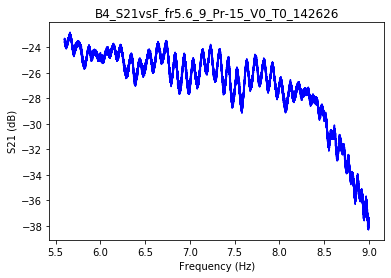

In [12]:
#################################################################################
# set up parameters
startFreq, endFreq = 5.6e9, 9e9
power = -15
numPoints, IFbandwidth, avg = 64001, 100000, 10
volt = 0

sampleID = 'B4'
suffix = 'SPlq'  # suffix to the file name
save_path = r'Z:\Experiments\Dirty Aluminum\Qubit\111919NbA\B4'
#save_path = r'Z:\User\Yebin\Project\Resonator Qi test\Samples\011918_W14_HF blow dry'
#save_path = r'Z:\User\Jaseung\projects\CSFQ\measurement\W16\testing'
#save_path = r'Z:\User\JJ\SFQ3\HYP1'
#save_path = r'Z:\User\Jaseung\projects\CSFQ\measurement\W19\B3\ADR1'
# save_path = r'Z:\User\Andrew\Flip-Chip_measurements\HYP2'
#################################################################################

# dictionary for parameters to be saved in log file.
header = 'freq (Hz) mag(dB) phase(degree) real imag'
para = dict([('startFreq (Hz)',startFreq),('endFreq (Hz)', endFreq),('power (dBm)',power)
             ,('numPoints',numPoints), ('IFbandwidth (Hz)', IFbandwidth),('avg',avg)
             ,('volt',volt), ('header', header)])

 #file setup
if fridgeType=='ADR2':
    FAA = float(lsci.tempGet('B')) # get temperature
else :
    FAA = 0 
timeStr = time.strftime("%H%M%S")
baseStr = sampleID + '_S21vsF_fr{:.9g}_{:.9g}_Pr{}_V{}_T{:.4g}_{}'
baseFileName = baseStr.format(startFreq/1e9, endFreq/1e9, power, volt, FAA, timeStr)
dataFileName = os.path.join(save_path, baseFileName + '.dat')                                 
logFileName =  os.path.join(save_path, baseFileName + '.json')

with open(logFileName, 'w') as f:
    json.dump(para,f,indent=4, sort_keys=True)

# plot setup
plotobj= myplots_py3.plot1D(ylabel = 'S21 (dB)', xlabel='Frequency (Hz)', title = baseFileName, plotStyle='b-')

# configure instrument
# pna.setupMeas()
# pna.setSweepType('linear')
pna.connect()
pna.setFreqStartEnd(startFreq, endFreq)
pna.setPwr(power)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.setIF(IFbandwidth)
pna.pwrOn()

# sim_glb.setVoltage(volt)
# sim_p1 = SIM.SIM(18, channel = 1)
# data initialization
#S21_mag_log_2D, S21_phase_2D = np.array([]), np.array([])
data = np.array([])

# configure
pna.avgClear()
        
# fetch data from PNA
freq, S21 = pna.getData(cplx=True) # S21 in linear scale
 
# S21 conversion
S21_real, S21_imag = np.real(S21), np.imag(S21)
S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
S21_mag_log = 20.0 * np.log10(S21_mag)    # dB

# make 2D array with freq, dB, phase
data = freq
data.shape = (freq.size, 1)
data = np.column_stack((data, S21_mag_log))
data = np.column_stack((data, S21_phase))
data = np.column_stack((data, S21_real))
data = np.column_stack((data, S21_imag))
     
# plot update
plotobj.update(freq/1e9, S21_mag_log)

## save files
f = open(dataFileName, 'wb') 
np.savetxt(f, data, fmt='%.9g', delimiter='\t') 


# Post measurement    
#sim_glb.setVoltage(0)
pna.pwrOff()
f.close()
plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
print('Measurement finished!!!')

In [6]:
sim_p1.setVoltage(0)

# S21 vs Freq vs Power, 2D power scan

In [5]:
%%time
#########################################################################################
# set up parameters
startFreq, endFreq =5.3e9, 5.305e9
numPoints, avg = 401, 10
IFStart, IFEnd = 5000, 100000 # Hz
startPwr, endPwr, stepPwr = -30,10, 2
Vglb_init = 0
Vchip_init = 0

sampleID = '081820Nb_D1'
suffix = ''
#save_path = r'Z:\User\Jaseung\projects\CSFQ\measurement\W11\C6\DR1'
#save_path = r'Z:\User\JJ\SFQ2\070717C\ADR2\E3'
#save_path = r'Z:\User\JJ\SFQ3\HYP1'
save_path = r'Z:\Experiments\Dirty Aluminum\Qubit\081820Nb_D1'
commentStr=''  # comment to be placed in the log file.
############################################################################################

# IFbandwidth scales up linearly as power increases.
IF_arr = np.linspace(IFStart, IFEnd, np.arange(startPwr, endPwr + stepPwr, stepPwr).size) 

# dictionary for parameters to be saved in json file. Solely for log.
xID, xStart, xEnd, xStep = 'Power (dBm)', startPwr, endPwr, stepPwr
yID, yStart, yEnd, yStep = 'Frequency (Hz)',startFreq, endFreq, (endFreq-startFreq)/(numPoints-1)
para = dict([('xID', xID), ('xStart', xStart), ('xEnd', xEnd)
             , ('yID', yID), ('yStart', yStart), ('yEnd', yEnd)
             , ('numPoints',numPoints), ('IFbandwidth start (Hz)', IF_arr[0]),('IFbandwidth end (Hz)', IF_arr[-1])
             , ('avg',avg), ('Vglb_init (V)',Vglb_init),('Vchip_init (V)',Vchip_init), ('comment', commentStr)])

# file setup
if fridgeType=='ADR2':
    FAA = float(lsci.tempGet('B')) # get temperature
else:
    FAA = 0
timeStr = time.strftime("%H%M%S")
baseStr = sampleID + '_'+'S21vsFvsP_fr{:.9g}_{:.9g}_Pr{:.4g}_{:.4g}_{:.4g}_V{:.3g}_T{:.4g}_{}_{}'
baseFileName = baseStr.format(startFreq/1e9, endFreq/1e9, startPwr, endPwr, stepPwr, Vglb_init, FAA, suffix, timeStr)
dataFileName_mag, dataFileName_phase  = (os.path.join(save_path, baseFileName + '_mag.dat'), 
                                         os.path.join(save_path, baseFileName + '_phase.dat'))
print('filename={}'.format(os.path.join(save_path, baseFileName + '_mag.dat')))
logFileName =  os.path.join(save_path, baseFileName + '.json')
with open(logFileName, 'w') as f:
    json.dump(para,f,indent=4, sort_keys=True)

# plot setup
plotobj= myplots_py3.plot2D(ylabel = 'Frequency(Hz)', xlabel='Power (dBm)', title = baseFileName)

# preconfigure instrument
pna.setupMeas()
pna.setSweepType('linear')
pna.setFreqStartEnd(startFreq, endFreq)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.pwrOn()
#sim_glb.setVoltage(Vglb_init)
#sim_chip.setVoltage(Vchip_init)

# data initialization
S21_mag_log_2D, S21_phase_2D = np.array([]), np.array([])

i=0
# sweep start
for pwr in np.arange(startPwr, endPwr + stepPwr, stepPwr): # traverse in [pmin, pmax].
    
    clear_output()
    print('startPwr={:.3g} dBm, endPwr={:.3g} dBm, current power={:.3g} dBm'.format(startPwr, endPwr, pwr))
    
    # configure
    pna.setIF(IF_arr[i]) 
    pna.setPwr(pwr)
    pna.avgClear()
    i += 1
    
    # fetch data from PNA
    freq, S21 = pna.getData(cplx=True) # S21 in linear scale
    
    # S21 conversion
    S21_real, S21_imag = np.real(S21), np.imag(S21)
    S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
    S21_mag_log = 20.0 * np.log10(S21_mag)    # dB
    
    if S21_mag_log_2D.size == 0: # when S21_mag_2D is empty
        S21_mag_log_2D = S21_mag_log
        #S21_mag_log_2D = S21_real
        S21_mag_log_2D.shape = (S21_mag_log.size, 1)
        S21_phase_2D = S21_phase
        #S21_phase_2D = S21_imag
        S21_phase_2D.shape = (S21_phase.size, 1)
    else:
        S21_mag_log_2D = np.column_stack((S21_mag_log_2D, S21_mag_log))
        S21_phase_2D = np.column_stack((S21_phase_2D, S21_phase))
        #S21_mag_log_2D = np.column_stack((S21_mag_log_2D, S21_real))
        #S21_phase_2D = np.column_stack((S21_phase_2D, S21_imag))
     
    # plot update
    extent = [startPwr, pwr, startFreq, endFreq]
    plotobj.update(S21_mag_log_2D, extent)
        
    # save data in each iteration
    f_mag = open(dataFileName_mag, 'wb') 
    f_phase = open(dataFileName_phase, 'wb') 
    np.savetxt(f_mag, S21_mag_log_2D, fmt='%.9g', delimiter='\t') 
    np.savetxt(f_phase, S21_phase_2D, fmt='%.9g', delimiter='\t')
    f_mag.close()
    f_phase.close()
    
# Post measurement  
# pna.setPwr(-50)
pna.pwrOff()
#sim_glb.setVoltage(0)
plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
print('Measurement complete!!!')


startPwr=-30 dBm, endPwr=10 dBm, current power=10 dBm
Measurement complete!!!
Wall time: 22.8 s


In [ ]:
%matplotlib
filename =r'Z:\User\Jaseung\projects\CSFQ\measurement\postdescumRes\Res1_S21vsFvsP_fr5.69532_5.69542_Pr-90_10_1_V0_T0.064__101617_mag.dat'
data = np.loadtxt(filename)
powerlist = np.arange(-90, 10,1)
# freq = 
for index, value in enumerate(powerlist):
    s21_mag = data[:,index]
    if index % 10 ==3:
        plt.plot(s21_mag )

In [ ]:
list(range(0,1,1))

# 2D S21 vs Pump Power (for TWPA)

In [ ]:
#########################################################################################
# set up parameters

##PNA Settings
startFreq, endFreq =3.0e9, 10e9 # [Hz] 6.775e9 , 6.945e9 #6.881e9, 6.885e9 # 6.904e9, 6.912e9 #Probe Frequency (PNA)
numPoints, avg = 801, 1
IFStart, IFEnd =500, 500 # [Hz] IF Bandwidth

##Pump Settings
startPwr, endPwr, stepPwr = -20, -15, 1 # [Hz] Pump Frequency sweep (startPwr,endPwr) and step (stepPwr) (Looks like variable is for power?)
pumpFreq = 7.606e9 #7.568e9

sampleID = 'TWPA'
suffix=''

# Save to directory here

#save_path = r'Z:\User\Jaseung\projects\CSFQ\measurement\W11\A8\ADR2'
#save_path = r'Z:\User\Jaseung\projects\CSFQ\measurement\IBM\384QB56\BF'
save_path = r'Z:\User\Andrew\TWPA' 
#save_path = r'Z:\Experiments\ADR2\Flux noise\FN04262017B\AB04_2'
commentStr=''  # comment to be placed in the log file.

############################################################################################

# IFbandwidth scales up linearly as power increases.
IF_arr = np.linspace(IFStart, IFEnd, np.arange(startPwr, endPwr + stepPwr, stepPwr).size) 

# dictionary for parameters to be saved in json file. Solely for log.
xID, xStart, xEnd, xStep = 'Power (dBm)', startPwr, endPwr, stepPwr
yID, yStart, yEnd, yStep = 'Frequency (Hz)',startFreq, endFreq, (endFreq-startFreq)/(numPoints-1)
para = dict([('xID', xID), ('xStart', xStart), ('xEnd', xEnd)
             , ('yID', yID), ('yStart', yStart), ('yEnd', yEnd)
             , ('numPoints',numPoints), ('IFbandwidth start (Hz)', IF_arr[0]),('IFbandwidth end (Hz)', IF_arr[-1])
             , ('avg',avg), ('pump Freq', ),('comment', commentStr)])


# file setup
if fridgeType=='ADR2': # Which fridge we are at.
    FAA = float(lsci.tempGet('B')) # get temperature
else:
    FAA = 0
timeStr = time.strftime("%H%M%S")
baseStr = sampleID + '_'+'S21vsFvsP_fr{:.9g}_{:.9g}_Pp{:.4g}_{:.4g}_{:.4g}_fp{:.9g}_T{:.4g}_{}_{}'
baseFileName = baseStr.format(startFreq/1e9, endFreq/1e9, startPwr, endPwr, stepPwr, pumpFreq, FAA, suffix, timeStr)
dataFileName_mag, dataFileName_phase  = (os.path.join(save_path, baseFileName + '_mag.dat'), 
                                         os.path.join(save_path, baseFileName + '_phase.dat'))
logFileName =  os.path.join(save_path, baseFileName + '.json') # Name on saved file.
with open(logFileName, 'w') as f:
    json.dump(para,f,indent=4, sort_keys=True)

# plot setup
plotobj= myplots_py3.plot2D(xlabel = 'Pump Power(dBm)', ylabel='Probe Frequency (Hz)', title = baseFileName)

# preconfigure instrument (for PNA)
pna.setupMeas()
pna.setSweepType('linear')
pna.setFreqStartEnd(startFreq, endFreq)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.pwrOn() #Turn on PNA Power

pump.setFreq(pumpFreq) #Set Pump Frequency
pump.pwrOn()

# data initialization
S21_mag_log_2D, S21_phase_2D = np.array([]), np.array([])

### 
i=0
# sweep start
for pwr in np.arange(startPwr, endPwr + stepPwr, stepPwr): # traverse in [pmin, pmax].
    
    clear_output()
    print('startPwr={:.3g} dBm, endPwr={:.3g} dBm, current power={:.3g} dBm'.format(startPwr, endPwr, pwr))
    
    # configure
    pna.setIF(IF_arr[i]) 
    pna.avgClear()
    pump.setPwr(pwr)
    i += 1

    # fetch data from PNA
    freq, S21 = pna.getData(cplx=True) # S21 in linear scale
    
    # S21 conversion
    S21_real, S21_imag = np.real(S21), np.imag(S21)
    S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
    S21_mag_log = 20.0 * np.log10(S21_mag)    # [dB]
    
    if S21_mag_log_2D.size == 0: # when S21_mag_2D is empty
        S21_mag_log_2D = S21_mag_log
        S21_mag_log_2D.shape = (S21_mag_log.size, 1)
        S21_phase_2D = S21_phase
        S21_phase_2D.shape = (S21_phase.size, 1)
    else:
        S21_mag_log_2D = np.column_stack((S21_mag_log_2D, S21_mag_log))
        S21_phase_2D = np.column_stack((S21_phase_2D, S21_phase))
     
    # 2D plot update
    extent = [startPwr, pwr, startFreq, endFreq]
    
    plotobj.update(S21_mag_log_2D, extent)
        
    # save data in each iteration
    f_mag = open(dataFileName_mag, 'wb') 
    f_phase = open(dataFileName_phase, 'wb') 
    np.savetxt(f_mag, S21_mag_log_2D, fmt='%.9g', delimiter='\t') 
    np.savetxt(f_phase, S21_phase_2D, fmt='%.9g', delimiter='\t')
    f_mag.close()
    f_phase.close()
    
# Post measurement    
pna.pwrOff()
plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
print('Measurement complete!!!')

# 2D S21 vs Pump Freq (for TWPA) 

In [11]:
# N=50
# VP1list = list(np.linspace(sim_p1.askVoltage(),-0,N))
# VP2list = list(np.linspace(sim_p2.askVoltage(),-0,N))
# VSlist = list(np.linspace(sim_s.askVoltage(),-1,N))
# for (vp1,vp2,vs) in zip(VP1list,VP2list,VSlist):
#     sim_p1.setVoltage(vp1)
#     sim_p2.setVoltage(vp2)
#     sim_s.setVoltage(vs)
#     time.sleep(0.5)
N=51
VP1list = list(np.linspace(-.7,0.225*4,N))
VP2list = list(np.linspace(-2.9,-0.35*4,N))
VSlist = list(np.linspace(1,-1.1,N))
for (vp1,vp2,vs) in zip(VP1list,VP2list,VSlist):
    sim_p1.setVoltage(vp1)
    sim_p2.setVoltage(vp2)
#     sim_s.setVoltage(vs)
    time.sleep(0.2)

In [5]:
sim_p1.setVoltage(0)
sim_p2.setVoltage(0)
# sim_c.setVoltage(0)

# S21 vs Freq vs Flux, 2D flux scan

In [9]:
%%time
###########################################################################
# set up parameters
startFreq, endFreq = 5.3e9, 5.305e9
power = -30
numPoints, IFbandwidth, avg = 401, 100000, 30
startVolt, endVolt, stepVolt = -8, 8, 0.1

sweepVoltSrc = 2 # 1: Vchip, 2: Vglb
Vglb_init = 0
Vglb_end = 0  
Vchip_init =0
Vchip_end = 0

sampleID = '081820Nb_D1'
suffix = 'P2'
#save_path = r'Z:\User\Jaseung\projects\CSFQ\measurement\W19\B3\ADR1'
#save_path = r'Z:\User\Andrew\Flip-Chip_measurements\HYP2'
save_path = r'Z:\Experiments\Dirty Aluminum\Qubit\081820Nb_D1'
commentStr =''
############################################################################

# dictionary for parameters to be saved in json file. Solely for log.
xID, xStart, xEnd, xStep = 'Volt (V)', startVolt, endVolt, stepVolt
yID, yStart, yEnd, yStep = 'Frequency (Hz)',startFreq, endFreq, (endFreq-startFreq)/(numPoints-1)
para = dict([('xID', xID), ('xStart', xStart), ('xEnd', xEnd)
             , ('yID', yID), ('yStart', yStart), ('yEnd', yEnd), ('Power (dBm)', power)
             , ('numPoints',numPoints), ('IFbandwidth (Hz)', IFbandwidth) 
             , ('avg',avg), ('comment', commentStr)])

# file setup
if fridgeType=='ADR2':
    FAA = float(lsci.tempGet('B')) # get temperature
else :
    FAA = 0    
timeStr = time.strftime("%H%M%S")
baseStr = sampleID + '_S21vsFvsV_fr{:.9g}_{:.9g}_Pr{:.4g}_V{}_{}_{}_T{:.4g}_{}_{}'
baseFileName = baseStr.format(startFreq/1e9, endFreq/1e9, power, startVolt, endVolt, stepVolt, FAA, suffix, timeStr)
dataFileName_mag, dataFileName_phase  = (os.path.join(save_path, baseFileName + '_mag.dat'), 
                                         os.path.join(save_path, baseFileName + '_phase.dat'))
logFileName =  os.path.join(save_path, baseFileName + '.json')
with open(logFileName, 'w') as f:
    json.dump(para,f,indent=4, sort_keys=True)

# plot setup
plotobj= myplots_py3.plot2D(ylabel = 'Frequency (Hz)', xlabel='Volt (V)', title = baseFileName)

# preconfigure instrument
# pna.connect()
pna.setupMeas()
time.sleep(0.1)
# pna.setSweepType('linear')
pna.setFreqStartEnd(startFreq, endFreq)
time.sleep(0.1)
pna.setPwr(power)
time.sleep(0.1)
pna.avgCount(avg)
time.sleep(0.1)
pna.numPoints(numPoints)
time.sleep(0.1)
pna.setIF(IFbandwidth)
time.sleep(0.1)
pna.pwrOn()
time.sleep(0.1)

#sim_glb.setVoltage(Vglb_init)
#sim_chip.setVoltage(Vchip_init)
# sim_glb.setVoltage(startVolt)
#sim_chip.setVoltage(startVolt)
# sim_s.setVoltage(startVolt)

time.sleep(2)

# data initialization
S21_mag_log_2D, S21_phase_2D = np.array([]), np.array([])

################ sweep start ################
for volt in np.arange(startVolt, endVolt + stepVolt, stepVolt): # traverse in [pmin, pmax].
    clear_output()
    print('startV={:.3g} V, endV={:.3g} V, current volt={:.3g} V'.format(startVolt, endVolt, volt))

    # configure
    if sweepVoltSrc==1:
        sim_p1.setVoltage(volt)
#         pass
    elif sweepVoltSrc==2:
        sim_p2.setVoltage(volt)
    elif sweepVoltSrc==3:
        sim_s.setVoltage(volt)
        
    #time.sleep(0.5)
    pna.avgClear()
    time.sleep(0.1)
    
    # fetch data from PNA
    freq, S21 = pna.getData(cplx=True) # S21 in linear scale
    time.sleep(0.1)
    
    # S21 conversion
    S21_real, S21_imag = np.real(S21), np.imag(S21)
    S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
    S21_mag_log = 20.0 * np.log10(S21_mag)    # dB
    
    if S21_mag_log_2D.size == 0: # when S21_mag_2D is empty
        S21_mag_log_2D = S21_mag_log
        #S21_mag_log_2D = S21_real
        S21_mag_log_2D.shape = (S21_mag_log.size, 1)
        S21_phase_2D = S21_phase
        #S21_phase_2D = S21_imag
        S21_phase_2D.shape = (S21_phase.size, 1)
    else:
        S21_mag_log_2D = np.column_stack((S21_mag_log_2D, S21_mag_log))
        S21_phase_2D = np.column_stack((S21_phase_2D, S21_phase))
        #S21_mag_log_2D = np.column_stack((S21_mag_log_2D, S21_real))
        #S21_phase_2D = np.column_stack((S21_phase_2D, S21_imag))
    
    # plot update
    extent = [startVolt, volt, startFreq, endFreq]
    plotobj.update(S21_mag_log_2D, extent)
        
    # save data in each iteration
#     f_mag = open(dataFileName_mag, 'w') 
#     f_phase = open(dataFileName_phase, 'w') 
#     np.savetxt(f_mag, S21_mag_log_2D, fmt='%.9g', delimiter='\t') 
#     np.savetxt(f_phase, S21_phase_2D, fmt='%.9g', delimiter='\t')
#     f_mag.close()
#     f_phase.close()
    
############## sweep end #########################    
# save at the end
f_mag = open(dataFileName_mag, 'wb') 
f_phase = open(dataFileName_phase, 'wb') 
np.savetxt(f_mag, S21_mag_log_2D, fmt='%.9g', delimiter='\t') 
np.savetxt(f_phase, S21_phase_2D, fmt='%.9g', delimiter='\t')
f_mag.close()
f_phase.close()

 
# Post measurement   
del S21_mag_log_2D, S21_phase_2D
pna.pwrOff()
time.sleep(0.1)
# sim_s.setVoltage(Vglb_end)
#sim_chip.setVoltage(Vchip_end)
plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
print('Measurement done!!!')

startV=-8 V, endV=8 V, current volt=8 V
Measurement done!!!
Wall time: 9min 54s


In [13]:
# %%time
###########################################################################
# Multi scan

# set up parameters
startFreq, endFreq = 6.1e9, 6.3e9
startFreq2, endFreq2 = 7e9, 7.2e9
startFreq3, endFreq3 = 7.94e9, 8.04e9
# startFreq, endFreq = 6.0204e9, 6.1502e9
power = -50
numPoints, IFbandwidth, avg = 801, 100000, 50
startVolt, endVolt, stepVolt = -1,1,.05

sweepVoltSrc = 2 # 1: Vchip, 2: Vglb
Vglb_init = 0
Vglb_end = 0 
Vchip_init =0
Vchip_end = 0

sampleID = 'PlaquetteC1'
suffix = 'Plaq1_multiscan'

# save_path = r'Z:\PHY-PRL-Labshare\Experiments\Dirty Aluminum\RF_SQUID\0506'
save_path = r'Z:\Experiments\JPM\JPM-SFQ\W0\Die2'

commentStr =''
############################################################################

# dictionary for parameters to be saved in json file. Solely for log.
xID, xStart, xEnd, xStep = 'Volt (V)', startVolt, endVolt, stepVolt
yID, yStart, yEnd, yStep = 'Frequency (Hz)',startFreq, endFreq, (endFreq-startFreq)/(numPoints-1)
para = dict([('xID', xID), ('xStart', xStart), ('xEnd', xEnd)
             , ('yID', yID), ('yStart', yStart), ('yEnd', yEnd), ('Power (dBm)', power)
             , ('numPoints',numPoints), ('IFbandwidth (Hz)', IFbandwidth) 
             , ('avg',avg), ('comment', commentStr)])

# file setup
if fridgeType=='ADR2':
    FAA = float(lsci.tempGet('B')) # get temperature
else :
    FAA = 0    
timeStr = time.strftime("%H%M%S")
baseStr = sampleID + '_S21vsFvsV_fr{:.9g}_{:.9g}_Pr{:.4g}_V{}_{}_{}_T{:.4g}_{}_{}'

baseFileName = baseStr.format(startFreq/1e9, endFreq/1e9, power, startVolt, endVolt, stepVolt, FAA, suffix, timeStr)
baseFileName2 = baseStr.format(startFreq2/1e9, endFreq2/1e9, power, startVolt, endVolt, stepVolt, FAA, suffix, timeStr)
baseFileName3 = baseStr.format(startFreq3/1e9, endFreq3/1e9, power, startVolt, endVolt, stepVolt, FAA, suffix, timeStr)

dataFileName_mag, dataFileName_phase  = (os.path.join(save_path, baseFileName + '_mag.dat'), 
                                         os.path.join(save_path, baseFileName + '_phase.dat'))

dataFileName_mag2, dataFileName_phase2  = (os.path.join(save_path, baseFileName2 + '_mag.dat'), 
                                         os.path.join(save_path, baseFileName2 + '_phase.dat'))

dataFileName_mag3, dataFileName_phase3  = (os.path.join(save_path, baseFileName3 + '_mag.dat'), 
                                         os.path.join(save_path, baseFileName3 + '_phase.dat'))


logFileName =  os.path.join(save_path, baseFileName + '.json')
with open(logFileName, 'w') as f:
    json.dump(para,f,indent=4, sort_keys=True)

# plot setup
plotobj= myplots_py3.plot2D(ylabel = 'Frequency (Hz)', xlabel='Volt (V)', title = baseFileName)

# preconfigure instrument
# pna.connect()
pna.setupMeas()
pna.setSweepType('linear')
pna.setFreqStartEnd(startFreq, endFreq)
pna.setPwr(power)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.setIF(IFbandwidth)
pna.pwrOn()

# sim_p1.setVoltage(-.5)
# sim_p2.setVoltage(-.5)

#sim_glb.setVoltage(Vglb_init)
#sim_chip.setVoltage(Vchip_init)
# sim_glb.setVoltage(startVolt)
#sim_chip.setVoltage(startVolt)
# sim_c.setVoltage(startVolt)

time.sleep(2)

# data initialization
S21_mag_log_2D, S21_phase_2D = np.array([]), np.array([])
S21_mag_log_2D2, S21_phase_2D2 = np.array([]), np.array([])
S21_mag_log_2D3, S21_phase_2D3 = np.array([]), np.array([])
# variable to keep track on iterations
i=0
################ sweep start ################
for volt in np.arange(startVolt, endVolt + stepVolt, stepVolt): # traverse in [pmin, pmax].
    clear_output()
    print('startV={:.3g} V, endV={:.3g} V, current volt={:.3g} V'.format(startVolt, endVolt, volt))

    # configure
    if sweepVoltSrc==1:
        sim_chip.setVoltage(volt)
#         pass
    elif sweepVoltSrc==2:
        sim_p1.setVoltage(volt)

        
    pna.setFreqStartEnd(startFreq, endFreq)    
    pna.avgClear()
    
    # fetch data from PNA
    freq, S21 = pna.getData(cplx=True) # S21 in linear scale
    
    # S21 conversion
    S21_real, S21_imag = np.real(S21), np.imag(S21)
    S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
    S21_mag_log = 20.0 * np.log10(S21_mag)    # dB
    
    if S21_mag_log_2D.size == 0: # when S21_mag_2D is empty
        S21_mag_log_2D = S21_mag_log
        S21_mag_log_2D.shape = (S21_mag_log.size, 1)
        S21_phase_2D = S21_phase
        S21_phase_2D.shape = (S21_phase.size, 1)
    else:
        S21_mag_log_2D = np.column_stack((S21_mag_log_2D, S21_mag_log))
        S21_phase_2D = np.column_stack((S21_phase_2D, S21_phase))
    
    
    pna.setFreqStartEnd(startFreq2, endFreq2)    
    pna.avgClear()
    
    # fetch data from PNA
    freq, S21 = pna.getData(cplx=True) # S21 in linear scale
    
    # S21 conversion
    S21_real, S21_imag = np.real(S21), np.imag(S21)
    S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
    S21_mag_log = 20.0 * np.log10(S21_mag)    # dB
    
    if S21_mag_log_2D2.size == 0: # when S21_mag_2D is empty
        S21_mag_log_2D2 = S21_mag_log
        S21_mag_log_2D2.shape = (S21_mag_log.size, 1)
        S21_phase_2D2 = S21_phase
        S21_phase_2D2.shape = (S21_phase.size, 1)
    else:
        S21_mag_log_2D2 = np.column_stack((S21_mag_log_2D2, S21_mag_log))
        S21_phase_2D2 = np.column_stack((S21_phase_2D2, S21_phase))
        
        
        
    pna.setFreqStartEnd(startFreq3, endFreq3)    
    pna.avgClear()
    
    # fetch data from PNA
    freq, S21 = pna.getData(cplx=True) # S21 in linear scale
    
    # S21 conversion
    S21_real, S21_imag = np.real(S21), np.imag(S21)
    S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
    S21_mag_log = 20.0 * np.log10(S21_mag)    # dB
    
    if S21_mag_log_2D3.size == 0: # when S21_mag_2D is empty
        S21_mag_log_2D3 = S21_mag_log
        S21_mag_log_2D3.shape = (S21_mag_log.size, 1)
        S21_phase_2D3 = S21_phase
        S21_phase_2D3.shape = (S21_phase.size, 1)
    else:
        S21_mag_log_2D3 = np.column_stack((S21_mag_log_2D3, S21_mag_log))
        S21_phase_2D3 = np.column_stack((S21_phase_2D3, S21_phase))
    
    
    
    # plot update
    extent = [startVolt, volt, startFreq, endFreq]
    i=i+1
    if i%10>0:
        continue
    plotobj.update(S21_mag_log_2D, extent)
    # save data in each iteration
#     f_mag = open(dataFileName_mag, 'w') 
#     f_phase = open(dataFileName_phase, 'w') 
#     np.savetxt(f_mag, S21_mag_log_2D, fmt='%.9g', delimiter='\t') 
#     np.savetxt(f_phase, S21_phase_2D, fmt='%.9g', delimiter='\t')
#     f_mag.close()
#     f_phase.close()
    
############## sweep end #########################    
# save at the end
# plotobj.update(S21_mag_log_2D, extent)
f_mag = open(dataFileName_mag, 'wb') 
f_phase = open(dataFileName_phase, 'wb') 
np.savetxt(f_mag, S21_mag_log_2D, fmt='%.9g', delimiter='\t') 
np.savetxt(f_phase, S21_phase_2D, fmt='%.9g', delimiter='\t')
f_mag.close()
f_phase.close()

f_mag2 = open(dataFileName_mag2, 'wb') 
f_phase2 = open(dataFileName_phase2, 'wb') 
np.savetxt(f_mag2, S21_mag_log_2D2, fmt='%.9g', delimiter='\t') 
np.savetxt(f_phase2, S21_phase_2D2, fmt='%.9g', delimiter='\t')
f_mag2.close()
f_phase2.close()

f_mag3 = open(dataFileName_mag3, 'wb') 
f_phase3 = open(dataFileName_phase3, 'wb') 
np.savetxt(f_mag3, S21_mag_log_2D3, fmt='%.9g', delimiter='\t') 
np.savetxt(f_phase3, S21_phase_2D3, fmt='%.9g', delimiter='\t')
f_mag3.close()
f_phase3.close()

 
# Post measurement   
del S21_mag_log_2D, S21_phase_2D
pna.pwrOff()
# sim_p2.setVoltage(Vglb_end)
#sim_chip.setVoltage(Vchip_end)
plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
print('Measurement done!!!')

# f50.close()

# N=50
# VP1list = list(np.linspace(0,0,N))
# VP2list = list(np.linspace(0,0,N))
# VSlist = list(np.linspace(5,0,N))
# for (vp1,vp2,vs) in zip(VP1list,VP2list,VSlist):
#     sim_p1.setVoltage(vp1)
#     sim_p2.setVoltage(vp2)
#     sim_s.setVoltage(vs)
#     time.sleep(0.5)

startV=-2 V, endV=2 V, current volt=2 V
Measurement done!!!


In [ ]:
sim_s.setVoltage(0)

In [ ]:
sim_v.getVoltage(3)

In [ ]:
%%time
###########################################################################
# set up parameters
def starkvsflux( flux, freqstart, freqend):
    startFreq, endFreq = 9.105e9, 9.129e9
    power = -70
    numPoints, IFbandwidth, avg = 1601, 100000, 100
    startVolt, endVolt, stepVolt = -5, 5, 0.5

    sweepVoltSrc = 2 # 1: Vchip, 2: Vglb
    Vglb_init = 0
    Vglb_end = 0  
    Vchip_init =0
    Vchip_end = 0

    sampleID = 'PLAQUETTE'
    suffix = 'Bobbin'
    #save_path = r'Z:\User\Jaseung\projects\CSFQ\measurement\W19\B3\ADR1'
    #save_path = r'Z:\User\Andrew\Flip-Chip_measurements\HYP2'
    save_path = r'C:\Users\Lab User\Desktop\Plaquette\RF_SQUID\0602'
    #save_path = r'Z:\User\JJ\SFQ3\HYP1'
    #save_path = r'Z:\User\Jaseung\projects\CSFQ\measurement\W14\B8\ADR2'
    #save_path=r'Z:\User\Jaseung\projects\CSFQ\measurement\IBM\384QB56\BF'
    #save_path=r'Z:\User\Jaseung\projects\CSFQ\measurement\W11\DD5\BF'
    #save_path = r'Z:\User\Jaseung\projects\CSFQ\measurement\W11\A8\ADR2'
    #save_path = r'Z:\User\Caleb\ch061'
    #save_path = r'C:\Users\Lab User\Desktop\Flux'
    commentStr =''
    ############################################################################

    # dictionary for parameters to be saved in json file. Solely for log.
    xID, xStart, xEnd, xStep = 'Volt (V)', startVolt, endVolt, stepVolt
    yID, yStart, yEnd, yStep = 'Frequency (Hz)',startFreq, endFreq, (endFreq-startFreq)/(numPoints-1)
    para = dict([('xID', xID), ('xStart', xStart), ('xEnd', xEnd)
                 , ('yID', yID), ('yStart', yStart), ('yEnd', yEnd), ('Power (dBm)', power)
                 , ('numPoints',numPoints), ('IFbandwidth (Hz)', IFbandwidth) 
                 , ('avg',avg), ('comment', commentStr)])

    # file setup
    if fridgeType=='ADR2':
        FAA = float(lsci.tempGet('B')) # get temperature
    else :
        FAA = 0    
    timeStr = time.strftime("%H%M%S")
    baseStr = sampleID + '_S21vsFvsV_fr{:.9g}_{:.9g}_Pr{:.4g}_V{}_{}_{}_T{:.4g}_{}_{}'
    baseFileName = baseStr.format(startFreq/1e9, endFreq/1e9, power, startVolt, endVolt, stepVolt, FAA, suffix, timeStr)
    dataFileName_mag, dataFileName_phase  = (os.path.join(save_path, baseFileName + '_mag.dat'), 
                                             os.path.join(save_path, baseFileName + '_phase.dat'))
    logFileName =  os.path.join(save_path, baseFileName + '.json')
    with open(logFileName, 'w') as f:
        json.dump(para,f,indent=4, sort_keys=True)

    # plot setup
    plotobj= myplots_py3.plot2D(ylabel = 'Frequency (Hz)', xlabel='Volt (V)', title = baseFileName)

    # preconfigure instrument
    pna.setupMeas()
    pna.setSweepType('linear')
    pna.setFreqStartEnd(startFreq, endFreq)
    pna.setPwr(power)
    pna.avgCount(avg)
    pna.numPoints(numPoints)
    pna.setIF(IFbandwidth)
    pna.pwrOn()

    #sim_glb.setVoltage(Vglb_init)
    #sim_chip.setVoltage(Vchip_init)
    # sim_glb.setVoltage(startVolt)
    #sim_chip.setVoltage(startVolt)
    sim_p.setVoltage(startVolt)

    time.sleep(2)

    # data initialization
    S21_mag_log_2D, S21_phase_2D = np.array([]), np.array([])

    ################ sweep start ################
    for volt in np.arange(startVolt, endVolt + stepVolt, stepVolt): # traverse in [pmin, pmax].
        clear_output()
        print('startV={:.3g} V, endV={:.3g} V, current volt={:.3g} V'.format(startVolt, endVolt, volt))

        # configure
        if sweepVoltSrc==1:
            sim_chip.setVoltage(volt)
    #         pass
        elif sweepVoltSrc==2:
            sim_p.setVoltage(volt)

        #time.sleep(0.5)
        pna.avgClear()

        # fetch data from PNA
        freq, S21 = pna.getData(cplx=True) # S21 in linear scale

        # S21 conversion
        S21_real, S21_imag = np.real(S21), np.imag(S21)
        S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
        S21_mag_log = 20.0 * np.log10(S21_mag)    # dB

        if S21_mag_log_2D.size == 0: # when S21_mag_2D is empty
            S21_mag_log_2D = S21_mag_log
            #S21_mag_log_2D = S21_real
            S21_mag_log_2D.shape = (S21_mag_log.size, 1)
            S21_phase_2D = S21_phase
            #S21_phase_2D = S21_imag
            S21_phase_2D.shape = (S21_phase.size, 1)
        else:
            S21_mag_log_2D = np.column_stack((S21_mag_log_2D, S21_mag_log))
            S21_phase_2D = np.column_stack((S21_phase_2D, S21_phase))
            #S21_mag_log_2D = np.column_stack((S21_mag_log_2D, S21_real))
            #S21_phase_2D = np.column_stack((S21_phase_2D, S21_imag))

        # plot update
        extent = [startVolt, volt, startFreq, endFreq]
        plotobj.update(S21_mag_log_2D, extent)

        # save data in each iteration
    #     f_mag = open(dataFileName_mag, 'w') 
    #     f_phase = open(dataFileName_phase, 'w') 
    #     np.savetxt(f_mag, S21_mag_log_2D, fmt='%.9g', delimiter='\t') 
    #     np.savetxt(f_phase, S21_phase_2D, fmt='%.9g', delimiter='\t')
    #     f_mag.close()
    #     f_phase.close()

    ############## sweep end #########################    
    # save at the end
    f_mag = open(dataFileName_mag, 'wb') 
    f_phase = open(dataFileName_phase, 'wb') 
    np.savetxt(f_mag, S21_mag_log_2D, fmt='%.9g', delimiter='\t') 
    np.savetxt(f_phase, S21_phase_2D, fmt='%.9g', delimiter='\t')
    f_mag.close()
    f_phase.close()


    # Post measurement   
    del S21_mag_log_2D, S21_phase_2D
    pna.pwrOff()
    sim_p.setVoltage(Vglb_end)
    #sim_chip.setVoltage(Vchip_end)
    plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
    print('Measurement done!!!')

# S21 vs Freq vs Flux, 3D flux scan

In [17]:
%%time
###########################################################################
# set up parameters
startFreq, endFreq = 6.685e9, 6.695e9 # 6.935e9, 6.9450e9 #6.7949e9 , 6.9676e9 #6.83e9, 6.894e9#6.856e9, 7.015e9 #6.85e9, 7.05e9
power = -43
numPoints, IFbandwidth, avg = 401, 200, 20
startVolt, endVolt, stepVolt = -5, 5, 0.5 #-5, 5, 0.05 #  #-15, 15, 0.4#-20, 20, 0.5 #-1, 1.5, 0.04
endV = 0  # end voltage for both global and onchip flux
startVolt1, endVolt1, stepVolt1 =-5, 5, 0.5

slop, Vglb_offset = 1, 0  # Vglb = slope * Vchip + Vglb_offset. Vglb_offset is the y-intercept in Vchip(x-axxis) vs Vglb (y) axis.

#save_path = 'Z:\User\JJ\SFQ2\C6'
save_path = 'Z:\Experiments\Dirty Aluminum\Qubit\111919NbA\D3'
suffix = 'D3'
commentStr= 'First2Dscan'.format(slope, Vglb_offset)
############################################################################

# dictionary for parameters to be saved in json file. Solely for log.
xID, xStart, xEnd, xStep = 'Volt (V)', startVolt, endVolt, stepVolt
yID, yStart, yEnd, yStep = 'Frequency (Hz)',startFreq, endFreq, (endFreq-startFreq)/(numPoints-1)
zID, zStart, zEnd, zStep = 'Volt (V)', startVolt1, endVolt1, stepVolt1
para = dict([('xID', xID), ('xStart', xStart), ('xEnd', xEnd)
             , ('yID', yID), ('yStart', yStart), ('yEnd', yEnd)
             ,('zID', zID), ('zStart', zStart), ('zEnd', zEnd), ('Power (dBm)', power)
             , ('numPoints',numPoints), ('IFbandwidth (Hz)', IFbandwidth) 
             , ('avg',avg), ('comment', commentStr)])

# log file setup
if fridgeType=='ADR2':
    FAA = float(lsci.tempGet('B')) # get temperature
else FAA = 0
timeStr = time.strftime("%H%M%S")
baseStr = 'S21vsFvsV_fr{:.9g}_{:.9g}_Pr{:.4g}_V{}_{}_{}_T{:.4g}_{}_{}'
baseFileName = baseStr.format(startFreq/1e9, endFreq/1e9, power, startVolt, endVolt, stepVolt, FAA, suffix,timeStr)
logFileName =  os.path.join(save_path, baseFileName + '.json')
with open(logFileName, 'w') as f:
    json.dump(para,f,indent=4, sort_keys=True)

# plot setup
#plotobj= myplots.plot2D(ylabel = 'Frequency(Hz)', xlabel='Volt (V)', title = 'S21 vs Freq vs Volt')

# preconfigure instrument
pna.setupMeas()
pna.setSweepType('linear')
pna.setFreqStartEnd(startFreq, endFreq)
pna.setPwr(power)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.setIF(IFbandwidth)
pna.pwrOn()

sim_glb.setVoltage(slope * startVolt + Vglb_offset)
sim_chip.setVoltage(startVolt)

time.sleep(2)

################ sweep start ################
for Vglb_offset in np.arange(startVolt1, endVolt1+stepVolt1, stepVolt1):
    # data initialization
    S21_mag_log_2D, S21_phase_2D = np.array([]), np.array([])

    #sim_glb.setVoltage(volt_outer)
    
    for volt_inner in np.arange(startVolt, endVolt + stepVolt, stepVolt): # traverse in [pmin, pmax].
        clear_output()
        print('Vglb_offset={:.3g}'.format(Vglb_offset))
        print('startV={:.3g} V, endV={:.3g} V, current volt={:.3g} V'.format(startVolt, endVolt, volt_inner))

        # configure
        sim_chip.setVoltage(volt_inner)
        sim_glb.setVoltage(slope * volt_inner + Vglb_offset)
        time.sleep(0.1)
        pna.avgClear()

        # fetch data from PNA
        freq, S21 = pna.getData(cplx=True) # S21 in linear scale

        # S21 conversion
        S21_real, S21_imag = np.real(S21), np.imag(S21)
        S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
        S21_mag_log = 20.0 * np.log10(S21_mag)    # dB

        if S21_mag_log_2D.size == 0: # when S21_mag_2D is empty
            S21_mag_log_2D = S21_mag_log
            S21_mag_log_2D.shape = (S21_mag_log.size, 1)
            S21_phase_2D = S21_phase
            S21_phase_2D.shape = (S21_phase.size, 1)
        else:
            S21_mag_log_2D = np.column_stack((S21_mag_log_2D, S21_mag_log))
            S21_phase_2D = np.column_stack((S21_phase_2D, S21_phase))

        # plot update
        #extent = [startVolt, volt, startFreq, endFreq]
        #plotobj.update(S21_mag_log_2D, extent)
     
    sim_chip.setVoltage(endV)
    time.sleep(3)
     
    # save at the end of inner loop
    fileIdStr = '_Vglb_offset={:.3g}'.format(Vglb_offset)
    dataFileName_mag, dataFileName_phase  = (os.path.join(save_path, baseFileName + fileIdStr + '_mag.dat'), 
                                             os.path.join(save_path, baseFileName + fileIdStr + '_phase.dat'))
    f_mag = open(dataFileName_mag, 'w') 
    f_phase = open(dataFileName_phase, 'w') 
    np.savetxt(f_mag, S21_mag_log_2D, fmt='%.9g', delimiter='\t') 
    np.savetxt(f_phase, S21_phase_2D, fmt='%.9g', delimiter='\t')
    f_mag.close()
    f_phase.close()
############## sweep end #########################    

# Post measurement   
del S21_mag_log_2D, S21_phase_2D
pna.pwrOff()
sim_glb.setVoltage(endV)
sim_chip.setVoltage(endV)
print('Measurement done!!!')

SyntaxError: invalid syntax (<unknown>, line 31)

# S21 vs Flux1 vs Flux2, 2D flux scan

In [ ]:
%reset

In [ ]:
import sys
for i in dir():
    try:
        print (i, eval(i).nbytes )
    except:
        print (i, sys.getsizeof(eval(i)) )

In [ ]:
%%time
##############################################################################
# set up parameters
readoutPwr = -75
readoutFreq = 7.14567e9 #6.7917e9 #6.792e9 #6.82e9 
numPoints, IFbandwidth, avg = 30, 500, 1
startVolt1, endVolt1, stepVolt1 =-3, 3, 0.02#-10, 10, 0.2 #-10, 10, 0.05 #-1.2, 1, 0.025 # outer for-loop
startVolt2, endVolt2, stepVolt2 =-20,20, 0.25 #-20, 20, 0.5 #-20, 20, 0.5 # y axis. Inner for-loop.
endVolt = 0

suffix = 'Q6_V2=onchip'
save_path =  r'Z:\User\Jaseung\projects\CSFQ\measurement\W10\B2\ADR2'
commentStr='with spec setup'
##############################################################################

xID, xStart, xEnd, xStep = 'Volt1 (V)', startVolt1, endVolt1, stepVolt1
yID, yStart, yEnd, yStep = 'Volt2 (V)', startVolt2, endVolt2, stepVolt2
para = dict([('xID', xID), ('xStart', xStart), ('xEnd', xEnd)
             , ('yID', yID), ('yStart', yStart), ('yEnd', yEnd)
             , ('readoutFreq (Hz)',readoutFreq),('power (dBm)',readoutPwr)
             , ('numPoints',numPoints), ('IFbandwidth (Hz)', IFbandwidth) 
             , ('avg',avg), ('comment', commentStr)])

# file setup
if fridgeType=='ADR2':
    FAA = float(lsci.tempGet('B')) # get temperature
else:
    FAA = 0

baseStr = 'S21vsV1vsV2_fr{:.9g}_Pr{:.4g}_V1_{}_{}_{}_V2_{}_{}_{}_T{:.4g}_{}'
baseFileName = baseStr.format(readoutFreq/1e9, readoutPwr, startVolt1, endVolt1, stepVolt1, startVolt2, endVolt2, stepVolt2, FAA, suffix)
dataFileName1  = os.path.join(save_path, baseFileName + '_mag.dat')
dataFileName2  = os.path.join(save_path, baseFileName + '_phase.dat')
logFileName =  os.path.join(save_path, baseFileName + '.json')
with open(logFileName, 'w') as f_log:
    json.dump(para, f_log, indent=4, sort_keys=True)

# plot setup
plotobj= myplots_py3.plot2D_4sub(xlabel1 = 'Voltage2 (V)', ylabel1='S21 (dB)', 
                             xlabel2 = 'Voltage2 (V)', ylabel2='Phase(degree)',
                             xlabel3 = 'Voltage, Vglb (V)', ylabel3='Voltage, Vchip (V)',
                             xlabel4 = 'Voltage, Vglb (V)', ylabel4='Voltage, Vchip (V)',
                             title = 'S21 vs Global Flux vs Gradiometric Flux', figsize=(12,8))

# preconfigure instrument
pna.setupMeas()
pna.setSweepType(mode='CW')
pna.setCWFreq(readoutFreq)
pna.setPwr(readoutPwr)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.setIF(IFbandwidth)
pna.pwrOn()

sim_glb.setVoltage(startVolt1)
time.sleep(2)
sim_chip.setVoltage(startVolt2)
time.sleep(2)

# data initialization
data1_2D, data2_2D = np.array([]), np.array([])

################ sweep start ################
#for specFreq in arange(startFreq, endFreq + stepFreq, stepFreq): # traverse in [pmin, pmax].
for volt1 in np.arange(startVolt1, endVolt1 + stepVolt1, stepVolt1):
    #configure para
    sim_glb.setVoltage(volt1)
    
    # data initialization
    xdata1, ydata1, ydata2 = np.array([]), np.array([]), np.array([])
    
    for volt2 in np.arange(startVolt2, endVolt2 + stepVolt2, stepVolt2):
        clear_output()
        print('startVolt1={:.3g}, endtvolt1={:.3g}'.format(startVolt1, endVolt1))
        print('startVolt2={:.3g}, endtvolt2={:.3g}'.format(startVolt2, endVolt2))
        print('volt1={:.3g}, volt2={:.3g}'.format(volt1, volt2)) 
        
        # configure
        pna.avgClear()
        sim_chip.setVoltage(volt2)
    
        # fetch data from PNA
        freq, S21= pna.getData(cplx=True) # S21 in linear scale
    
        # S21 conversion
        S21_real, S21_imag = np.real(S21), np.imag(S21)
        S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
        S21_mag_log = 20.0 * np.log10(S21_mag)    # dB

        S21_mag_log_avg = np.average(S21_mag_log) 
        S21_phase_avg = np.average(S21_phase)

        xdata1 = np.append(xdata1, volt2)
        ydata1 = np.append(ydata1, S21_mag_log_avg)
        ydata2 = np.append(ydata2, S21_phase_avg)

        # plot and update
        plotobj.update1D(xdata1, ydata1, xdata1, ydata2)

    
    if data1_2D.size == 0: # when S21_mag_2D is empty
        data1_2D = ydata1 # make 2D array
        data1_2D.shape = (data1_2D.size, 1)
        data2_2D = ydata2
        data2_2D.shape = (data2_2D.size, 1)
        
    else:
        data1_2D = np.column_stack((data1_2D, ydata1))
        data2_2D = np.column_stack((data2_2D, ydata2))
             
    # plot and update
    extent = [startVolt1, volt1, startVolt2, endVolt2]
    plotobj.update2D(data1_2D, data2_2D, extent, cmap='Blues_r')
    
    # save data in each iteration
    f_mag = open(dataFileName1, 'wb') 
    f_phase = open(dataFileName2, 'wb') 
    np.savetxt(f_mag, data1_2D, fmt='%.9g', delimiter='\t') 
    np.savetxt(f_phase, data2_2D, fmt='%.9g', delimiter='\t')
    f_mag.close()
    f_phase.close()
     
############## sweep end #########################    

# Post measurement    
pna.pwrOff()
pna.setSweepType(mode='linear')
sim_glb.setVoltage(endVolt)
sim_chip.setVoltage(endVolt)
f_log.close()
plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
print('Measurement done!!!')

# S21 vs Freq vs Flux (linear comb. of flux1 and flux2), 2D

In [ ]:
reload(myplots)

In [ ]:
%%time
###########################################################################
# set up parameters
startFreq, endFreq =  6.77e9, 6.81e9 #6.83e9, 6.894e9#6.856e9, 7.015e9 #6.85e9, 7.05e9
power = -60
numPoints, IFbandwidth, avg = 801, 1000, 1
startVolt, endVolt, stepVolt =-20, 20, 0.2#-20, 20, 0.5 #-1, 1.5, 0.04
endV = 0

slope, Vglb_offset =-0.3378,2.4 # 0.2107, 0# 2.484#-0.3378, -0.9641# -0.0659, 0.7   # offset means Vglb when Vchip=0

#save_path = 'Z:\User\JJ\sput\M5_1_spec'
save_path = 'Z:\User\Jaseung\projects\CSFQ\measurement\W3\B7\BlueFors\Jan2017\S21vsFreqvsV'
suffix = 'Q1_xID=Vchip_slope{}_Vglb_offset{}'.format(slope, Vglb_offset)
comment= 'slope={:.3g}, Vglb_offset={:.3g}'.format(slope, Vglb_offset)

plottitle = 'S21 vs Freq vs Vchip, Vglb_offset={:.3g}'.format(Vglb_offset)

############################################################################

# dictionary for parameters to be saved in json file. Solely for log.
xID, xStart, xEnd, xStep = 'Volt (V)', startVolt, endVolt, stepVolt
yID, yStart, yEnd, yStep = 'Frequency (Hz)',startFreq, endFreq, (endFreq-startFreq)/(numPoints-1)
para = dict([('xID', xID), ('xStart', xStart), ('xEnd', xEnd)
             , ('yID', yID), ('yStart', yStart), ('yEnd', yEnd), ('Power (dBm)', power)
             , ('numPoints',numPoints), ('IFbandwidth (Hz)', IFbandwidth) 
             , ('avg',avg), ('comment', comment)])

# file setup
if fridgeType=='ADR2':
    FAA = float(lsci.tempGet('B')) # get temperature
else FAA = 0

baseStr = 'S21vsFvsV_fr{:.9g}_{:.9g}_Pr{:.4g}_V{}_{}_{}_T{:.4g}_{}'
baseFileName = baseStr.format(startFreq/1e9, endFreq/1e9, power, startVolt, endVolt, stepVolt, FAA, suffix)
dataFileName_mag, dataFileName_phase  = (os.path.join(save_path, baseFileName + '_mag.dat'), 
                                         os.path.join(save_path, baseFileName + '_phase.dat'))
logFileName =  os.path.join(save_path, baseFileName + '.json')
with open(logFileName, 'w') as f:
    json.dump(para,f,indent=4, sort_keys=True)

# plot setup
plotobj= myplots.plot2D(ylabel = 'Frequency(Hz)', xlabel='Volt (V)', title = plottitle)

# preconfigure instrument
pna.setupMeas()
pna.setSweepType('linear')
pna.setFreqStartEnd(startFreq, endFreq)
pna.setPwr(power)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.setIF(IFbandwidth)
pna.pwrOn()

sim_glb.setVoltage(slope*startVolt+Vglb_offset)
sim_chip.setVoltage(startVolt)
time.sleep(2)

# data initialization
S21_mag_log_2D, S21_phase_2D = np.array([]), np.array([])

################ sweep start ################
for volt_chip in np.arange(startVolt, endVolt + stepVolt, stepVolt): # traverse in [pmin, pmax].
    # configure
    volt_glb =  slope * volt_chip + Vglb_offset
    #volt_glb = -1/slope* (volt_chip-20) - 0.55
    clear_output()
    print('volt_glb={:.3g}, volt_chip={:.3g}'.format(volt_glb, volt_chip))
    sim_chip.setVoltage(volt_chip)
    sim_glb.setVoltage(volt_glb)
    
    time.sleep(0.1)
    pna.avgClear()
    
    # fetch data from PNA
    freq, S21 = pna.getData(cplx=True) # S21 in linear scale
    
    # S21 conversion
    S21_real, S21_imag = np.real(S21), np.imag(S21)
    S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
    S21_mag_log = 20.0 * np.log10(S21_mag)    # dB
    
    if S21_mag_log_2D.size == 0: # when S21_mag_2D is empty
        S21_mag_log_2D = S21_mag_log
        S21_mag_log_2D.shape = (S21_mag_log.size, 1)
        S21_phase_2D = S21_phase
        S21_phase_2D.shape = (S21_phase.size, 1)
    else:
        S21_mag_log_2D = np.column_stack((S21_mag_log_2D, S21_mag_log))
        S21_phase_2D = np.column_stack((S21_phase_2D, S21_phase))
     
    # plot update
    extent = [startVolt, volt_chip, startFreq, endFreq]
    plotobj.update(S21_mag_log_2D, extent)
        
    # save data in each iteration
    f_mag = open(dataFileName_mag, 'w') 
    f_phase = open(dataFileName_phase, 'w') 
    np.savetxt(f_mag, S21_mag_log_2D, fmt='%.9g', delimiter='\t') 
    np.savetxt(f_phase, S21_phase_2D, fmt='%.9g', delimiter='\t')
    f_mag.close()
    f_phase.close()
    
############## sweep end #########################    

# Post measurement    
pna.pwrOff()
sim_glb.setVoltage(endV)
sim_chip.setVoltage(endV)
plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
print('Measurement done!!!')

# S21 vs Freq, 1D continuous sweep, no save

In [ ]:
# set up parameters
startFreq, endFreq = 6e9, 6.867e9
power = -60
numPoints, IFbandwidth, avg = 401, 500, 1
#volt = 0.0 # -0.65 # -2.05  #2.4

# plot setup
plotobj= myplots_py3.plot1D(ylabel = 'S21 (dB)', xlabel='Frequency (Hz)', title = 'S21 vs Freq'
                        , plotStyle='b-o')

# preconfigure instrument
pna.setupMeas()
pna.setSweepType('linear')
pna.setFreqStartEnd(startFreq, endFreq)
pna.setPwr(power)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.setIF(IFbandwidth)
pna.pwrOn()

#spec.pwrOff()
#sim_glb.setVoltage(volt)

# data initialization
S21_mag_log_2D, S21_phase_2D = np.array([]), np.array([])

################ sweep start ################
for i in range(400):
    # configure
    pna.avgClear()
        
    # fetch data from PNA
    freq, S21 = pna.getData(cplx=True) # S21 in linear scale
    
    # S21 conversion
    S21_real, S21_imag = np.real(S21), np.imag(S21)
    S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
    S21_mag_log = 20.0 * np.log10(S21_mag)    # dB
    
    # plot update
    plotobj.update(freq/1e9, S21_mag_log)
       
############## sweep end #########################    

# Post measurement    
pna.pwrOff()


# S21 vs Flux, 1D, CW mode

In [ ]:
####################################################################################################
# set up parameters
readoutFreq = 6.9078e9 #6.9180e9 #6.873328e9
readoutPwr = -70
numPoints, IFbandwidth, avg = 50, 100, 1
startVolt, endVolt, stepVolt =0.2, 0.5, 0.003
endV = 0
sweepNumber = 1
timesleep = 0.1 # sec

sampleID = 'IBM384QB56'
suffix = 'Q2CSFQ'
# save_path = 'C:\Users\Lab User\Desktop\W4'
#save_path = r'Z:\User\Jaseung\projects\CSFQ\measurement\W11\DD5\ADR2'
save_path = r'Z:\User\Jaseung\projects\CSFQ\measurement\IBM\384QB56\BF\With_circulators'
#save_path = r'Y:\User\Caleb'
######################################################################################################

# dictionary for parameters to be saved in json file. Solely for log.
header = '{:s} {:s} {:s}'.format('Frequency(Hz)', 'mag(dB)', 'phase(degree)')
para = dict([('readout Freq (Hz)',readoutFreq),('readout Power (dBm)', readoutPwr),('numPoints',numPoints),
             ('IFbandwidth (Hz)', IFbandwidth),('avg',avg),('start volt (V)',startVolt),('end volt (V)', endVolt),
             ('step volt (V)',stepVolt), ('header', header)])


# file setup
if fridgeType=='ADR2':
    FAA = float(lsci.tempGet('B')) # get temperature
else :
    FAA = 0    
timeStr = time.strftime("%H%M%S")
baseStr = sampleID + '_S21vsV_fr{:.9g}_Pr{:.9g}_V{:.9g}_{:.9g}_{:.9g}_T{:.3g}_{}_{}'
baseFileName = baseStr.format(readoutFreq/1e9, readoutPwr, startVolt, endVolt, stepVolt, FAA, suffix, timeStr)
dataFileName  = os.path.join(save_path, baseFileName + '.dat')
logFileName = os.path.join(save_path, baseFileName + '.json')
with open(logFileName, 'w') as f:
    json.dump(para,f,indent=4, sort_keys=True)

f_data = open(dataFileName, 'a')
   
# plot setup
plotobj= myplots_py3.plot1D_2sub(xlabel1 = '', ylabel1='S21 (dB)', 
                             xlabel2 = 'Volt (V)', ylabel2='Phase(degree)',
                             title = baseFileName, plotStyle='b-')

# preconfigure instrument
pna.setupMeas()
pna.setSweepType('CW')
pna.setCWFreq(readoutFreq)
pna.setPwr(readoutPwr)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.setIF(IFbandwidth)
pna.pwrOn()

#spec.pwrOff()
sim_glb.setVoltage(startVolt)
#sim_chip.setVoltage(0)

#sim_glb.setVoltage(0.148)
#sim_chip.setVoltage(startVolt)

# data initialization
xdata, ydata1, ydata2 = np.array([]), np.array([]),np.array([])

# sweeper obj
sweeper = myutils.Sweeper1D(start=startVolt, end=endVolt, 
                            step=stepVolt, sweepNum=sweepNumber)

################ sweep start ################
#for specFreq in arange(startFreq, endFreq + stepFreq, stepFreq): # traverse in [pmin, pmax].
print(sweeper.stop())

while not sweeper.stop(): 
    # configure
    sim_glb.setVoltage(sweeper.curr_val)
    #sim_chip.setVoltage(sweeper.curr_val)
    
    time.sleep(timesleep) # sec
    pna.avgClear()
    
    # fetch data from PNA
    freq, S21= pna.getData(cplx=True) # S21 in linear scale
    
    # S21 conversion
    S21_real, S21_imag = np.real(S21), np.imag(S21)
    S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
    S21_mag_log = 20.0 * np.log10(S21_mag)    # dB
    S21_mag_log_avg = np.average(S21_mag_log) 
    S21_phase_avg = np.average(S21_phase)
    
    # create spec freq, S21 1D array
    xdata = np.append(xdata, sweeper.curr_val)
    ydata1 = np.append(ydata1, S21_mag_log_avg)
    ydata2 = np.append(ydata2, S21_phase_avg)
    
    # plot and update
    plotobj.update(xdata, ydata1, xdata, ydata2)
    
    # save data in each iteration
    string = '{:.9g}\t{:.3g}\t{:.3g} \n'.format(sweeper.curr_val, S21_mag_log_avg,S21_phase_avg)
    f_data.write(string)
    
    # update sweep
    sweeper.update()
############## sweep end #########################    

# Post measurement    
pna.pwrOff()
pna.setSweepType(mode='linear')
sim_glb.setVoltage(endV)
#sim_chip.setVoltage(endV)
f_data.close()
f.close()
plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
print('Measurement done!!')


# S21 vs P, 1D, CW mode

In [ ]:
##################################################################
# set up parameters
readoutFreq = 6.103142e9 #6.873328e9
numPoints, IFbandwidth, avg = 50, 200, 1
startPwr, endPwr, stepPwr = -70, -40, 0.5
volt = 0
sweepNumber = 1

sampleID = ''
suffix = ''  # suffix to the file name
save_path = 'C:\Users\Lab User\Desktop\JJ\A4'
#save_path = 'Z:\User\Jaseung\projects\CSFQ\W1\C5\S21vsFreq'
##################################################################

# dictionary for parameters to be saved in json file. Solely for log.
para = dict([('readout Freq (Hz)',readoutFreq),('numPoints',numPoints)
             ,('IFbandwidth', IFbandwidth),('avg',avg)
             ,('Power start (dBm)',startPwr),('Power end (dBm)',endPwr), ('Power step (dBm)',stepPwr)
             ,('voltage (V)',volt)])

# file setup
FAA = float(lsci.tempGet('B')) # unicode to num    
baseStr = sampleID + '_S21vsP_fr{:.9g}_Pr{:.9g}_{:.9g}_{:.9g}_V{:.3g}_T{:.4g}_{}'
baseFileName = baseStr.format(readoutFreq/1e9, startPwr, endPwr, stepPwr, volt, FAA, suffix)
dataFileName  = os.path.join(save_path, baseFileName + '.dat')
logFileName = os.path.join(save_path, baseFileName + '.json')
with open(logFileName, 'w') as f:
    json.dump(para,f,indent=4, sort_keys=True)
f_data = open(dataFileName, 'a')
    
# plot setup
plotobj= myplots.plot1D_2sub(xlabel1 = '', ylabel1='S21 (dB)', 
                             xlabel2 = 'Volt (V)', ylabel2='Phase(degree)',
                             title = 'S21 vs Volt', plotStyle='b-o')

# preconfigure instrument
pna.setupMeas()
pna.setSweepType('CW')
pna.setCWFreq(readoutFreq)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.setIF(IFbandwidth)
pna.pwrOn()
#spec.pwrOff()
sim_glb.setVoltage(volt)

# data initialization
xdata, ydata1, ydata2 = np.array([]), np.array([]),np.array([])

# sweeper obj
sweeper = myutils.Sweeper1D(start=startPwr, end=endPwr, step=stepPwr, sweepNum=sweepNumber)

################ sweep start ################
while not sweeper.stop(): 
    # configure
    pna.setPwr(sweeper.curr_val)
    pna.avgClear()
    
    # fetch data from PNA
    freq, S21= pna.getData(cplx=True) # S21 in linear scale
    
    # S21 conversion
    S21_real, S21_imag = np.real(S21), np.imag(S21)
    S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
    S21_mag_log = 20.0 * np.log10(S21_mag)    # dB
    S21_mag_log_avg = np.average(S21_mag_log) 
    S21_phase_avg = np.average(S21_phase)
    
    # create spec freq, S21 1D array
    xdata = np.append(xdata, sweeper.curr_val)
    ydata1 = np.append(ydata1, S21_mag_log_avg)
    ydata2 = np.append(ydata2, S21_phase_avg)
    
    # plot and update
    plotobj.update(xdata, ydata1, xdata, ydata2)
    
    # save data in each iteration
    string = '{:.9g}\t{:.3g}\t{:.3g} \n'.format(sweeper.curr_val, S21_mag_log_avg,S21_phase_avg)
    f_data.write(string)
    
    # update sweep
    sweeper.update()
############## sweep end #########################    

# Post measurement    
pna.pwrOff()
pna.setSweepType(mode='linear')
#sim_glb.setVoltage(endV)
f_data.close()
plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
print('Measurement finished!!!')

# Resonator Power scan

In [ ]:
#################################################################################
# set up parameters
startFreq, endFreq =6.40775e9, 6.40815e9
power = -80
numPoints, IFbandwidth, avg = 51, 1, 3
volt = 0 # -0.65 # -2.05  #2.4

sampleID = 'W19B4'
suffix = '6Rs'  # suffix to the file name
#save_path = r'Z:\User\Yebin\Project\Resonator Qi test\Samples\12062017_W10'
save_path = r'Z:\User\Yebin\Project\Resonator Qi test\Samples\05232018-W19-HF after photolithography_ADR1'
#################################################################################

# dictionary for parameters to be saved in log file.
header = 'freq (Hz) mag(dB) phase(degree) real imag'
para = dict([('startFreq (Hz)',startFreq),('endFreq (Hz)', endFreq),('power (dBm)',power)
             ,('numPoints',numPoints), ('IFbandwidth (Hz)', IFbandwidth),('avg',avg)
             ,('volt',volt), ('header', header)])

# file setup
if fridgeType=='ADR2':
    FAA = float(lsci.tempGet('B')) # get temperature
else :
    FAA = 0 
timeStr = time.strftime("%H%M%S")
baseStr = sampleID + '_S21vsF_fr{:.9g}_{:.9g}_Pr{}_V{}_T{:.4g}_{}'
baseFileName = baseStr.format(startFreq/1e9, endFreq/1e9, power, volt, FAA, timeStr)
dataFileName = os.path.join(save_path, baseFileName + '.dat')                                 
logFileName =  os.path.join(save_path, baseFileName + '.json')

with open(logFileName, 'w') as f:
    json.dump(para,f,indent=4, sort_keys=True)

# plot setup
plotobj= myplots_py3.plot1D(ylabel = 'S21 (dB)', xlabel='Frequency (Hz)', title = baseFileName, plotStyle='b-')

# configure instrument
pna.setupMeas()
pna.setSweepType('linear')
pna.setFreqStartEnd(startFreq, endFreq)
pna.setPwr(power)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.setIF(IFbandwidth)
pna.pwrOn()

#sim_glb.setVoltage(volt)

# data initialization
#S21_mag_log_2D, S21_phase_2D = np.array([]), np.array([])
data = np.array([])

# configure
pna.avgClear()
        
# fetch data from PNA
freq, S21 = pna.getData(cplx=True) # S21 in linear scale
 
# S21 conversion
S21_real, S21_imag = np.real(S21), np.imag(S21)
S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
S21_mag_log = 20.0 * np.log10(S21_mag)    # dB

# make 2D array with freq, dB, phase
data = freq
data.shape = (freq.size, 1)
data = np.column_stack((data, S21_mag_log))
data = np.column_stack((data, S21_phase))
data = np.column_stack((data, S21_real))
data = np.column_stack((data, S21_imag))
     
# plot update
plotobj.update(freq/1e9, S21_mag_log)

# save files
f = open(dataFileName, 'wb') 
np.savetxt(f, data, fmt='%.9g', delimiter='\t') 

# Post measurement   

pna.pwrOff()
f.close()
plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
print('Measurement finished!!!')

In [ ]:
def cav1d(startFreq, endFreq,power,numPoints, IFbandwidth, avg,width,suffix = 'R5',sampleID ='W5', \
          save_path=r'Z:\User\Yebin\Project\Resonator Qi test\Samples\02192018_W5Res_HFinCNF_Post descum\data\R5'):
    #################################################################################
    # set up parameters   
    volt = 0 # -0.65 # -2.05  #2.4
    #suffix = 'Q4'  # suffix to the file name
    #################################################################################

    # dictionary for parameters to be saved in log file.
    header = 'freq (Hz) mag(dB) phase(degree) real imag'
    para = dict([('power (dBm)',power),('startFreq (Hz)',startFreq),('endFreq (Hz)', endFreq)
                 ,('numPoints',numPoints), ('IFbandwidth (Hz)', IFbandwidth),('avg',avg)
                 ,('volt',volt), ('header', header)])

    # file setup
    if fridgeType=='ADR2':
        FAA = float(lsci.tempGet('B')) # get temperature
    else :
        FAA = 0.0 
    timeStr = time.strftime("%H%M%S")
    baseStr = sampleID + '_S21vsF_Pr{}_fr{:.9g}_{:.9g}_V{}_T{:.4g}_{}_{}_{}'
    baseFileName = baseStr.format(power,startFreq/1e9, endFreq/1e9, volt, FAA,width,suffix, timeStr)
    dataFileName = os.path.join(save_path, baseFileName + '.dat')                                 
    logFileName =  os.path.join(save_path, baseFileName + '.json')

    with open(logFileName, 'w') as f:
        json.dump(para,f,indent=4, sort_keys=True)

    # plot setup
    plotobj= myplots_py3.plot1D(ylabel = 'S21 (dB)', xlabel='Frequency (Hz)', title = baseFileName, plotStyle='b-')

    # configure instrument
    pna.setupMeas()
    pna.setSweepType('linear')
    pna.setFreqStartEnd(startFreq, endFreq)
    pna.setPwr(power)
    pna.avgCount(avg)
    pna.numPoints(numPoints)
    pna.setIF(IFbandwidth)
    pna.pwrOn()

    #sim_glb.setVoltage(volt)

    # data initialization
    #S21_mag_log_2D, S21_phase_2D = np.array([]), np.array([])
    data = np.array([])

    # configure
    pna.avgClear()

    # fetch data from PNA
    freq, S21 = pna.getData(cplx=True) # S21 in linear scale

    # S21 conversion
    S21_real, S21_imag = np.real(S21), np.imag(S21)
    S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
    S21_mag_log = 20.0 * np.log10(S21_mag)    # dB

    # make 2D array with freq, dB, phase
    data = freq
    data.shape = (freq.size, 1)
    data = np.column_stack((data, S21_mag_log))
    data = np.column_stack((data, S21_phase))
    data = np.column_stack((data, S21_real))
    data = np.column_stack((data, S21_imag))

    # plot update
    plotobj.update(freq/1e9, S21_mag_log)

    # save files
    f = open(dataFileName, 'wb') 
    np.savetxt(f, data, fmt='%.9g', delimiter='\t') 

    # Post measurement    
    pna.pwrOff()
    f.close()
    plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
    print('Measurement finished!!!')
    return data

In [ ]:
def Get_S21(freqStart, freqEnd,power,numPoints, IFbandwidth, avg,wideSpan,suffix = 'Q4',sampleID ='W14', \
          save_path=r'Z:\User\Yebin\Project\Resonator Qi test\Samples'):
    #get data 1 WS scan
    freqCenter = (freqStart + freqEnd)/2
    freqStartW = freqCenter - wideSpan/2
    freqEndW = freqCenter + wideSpan/2 
    dataS = cav1d(freqStart, freqEnd,power,numPoints,IFbandwidth, avg,'SS',suffix,sampleID,save_path) 
    dataW = cav1d(freqStartW, freqEndW,power,numPoints,IFbandwidth, avg,'WS',suffix,sampleID,save_path) 
    
    volt = 0
    
    # fit baseline
    p = len(dataW[:,0])
    w = int(p/5)
    freqW,freqW1,freqW2 = [],dataW[0:w,0] , dataW[(p-w):p,0]
    freqW.extend(freqW1)
    freqW.extend(freqW2)
    magdataW,magdataW1,magdataW2 =  [],dataW[0:w,1], dataW[(p-w):p,1]
    magdataW.extend(magdataW1)
    magdataW.extend(magdataW2)
    phasedataW,phasedataW1,phasedataW2 =  [],dataW[0:w,2] , dataW[(p-w):p,2]
    phasedataW.extend(phasedataW1)
    phasedataW.extend(phasedataW2)
    magBasePara = np.polyfit(freqW,magdataW,2)
    phaseBasePara = np.polyfit(freqW,phasedataW,1)
    magBaseFit = np.polyval(magBasePara,dataS[:,0])
    phaseBaseFit = np.polyval(phaseBasePara,dataS[:,0])
    # base line subtraction
    magSub = dataS[:,1] - magBaseFit
    phaseSub = dataS[:,2] - phaseBaseFit
    dataS[:,1] = magSub
    dataS[:,2] = phaseSub
    # dictionary for parameters to be saved in log file.
    header = 'freq (Hz) mag(dB) phase(degree) real imag'
    para = dict([('power (dBm)',power),('startFreq (Hz)',startFreq),('endFreq (Hz)', endFreq)
                 ,('numPoints',numPoints), ('IFbandwidth (Hz)', IFbandwidth),('avg',avg)
                 ,('volt',volt), ('header', header)])
    # file setup
    if fridgeType=='ADR2':
        FAA = float(lsci.tempGet('B')) # get temperature
    else :
        FAA = 0 
    timeStr = time.strftime("%H%M%S")
    baseStr = sampleID + '_S21vsF_Sub_Pr{}_fr{:.9g}_{:.9g}_V{}_T{:.4g}_{}_{}'
    baseFileName = baseStr.format(power,startFreq/1e9, endFreq/1e9, volt, FAA,suffix, timeStr)
    dataFileName = os.path.join(save_path, baseFileName + '.dat')                                 
    logFileName =  os.path.join(save_path, baseFileName + '.json')
    with open(logFileName, 'w') as f:
        json.dump(para,f,indent=4, sort_keys=True)
    # save files
    f = open(dataFileName, 'wb') 
    np.savetxt(f, data, fmt='%.9g', delimiter='\t') 
    f.close()

In [ ]:
startFreq, endFreq =6.40775e9, 6.40815e9
wideSpan = 10e6
suffix = 'R5_RTAtt10'
sampleID = 'W19B4'
save_path =  r'Z:\User\Yebin\Project\Resonator Qi test\Samples\05232018-W19-HF after photolithography_ADR1\R5'
'''
power = [10,
         5,0,-5,-10,-15,-20,-25,-30,-35,
         -40,-45,-50,-55,-60,-65,-70,-75,-80,-85,-90]
IFbandwidth = [10,
               10,10,10,10,10,10,10,10,10,
               1,1,1,1,1,1,1,1,1,1,1]
avg = [4,
       4,4,4,8,8,8,10,10,10,
       10,15,20,30,40,80,80,160,160,250,320]
numPoints = [501,
             501,501,501,301,301,301,201,201,201,101,
            101,101,101,101,101,101,101,101,101,101]
'''
#####
power = [10,
         5,0,-5,-10,-15,-20,-25,-30,-35,
         -40,-45,-50,-55,-60,-65,-70,-75,-80,-85,-90]
IFbandwidth = [1000,
               1000,1000,1000,1000,1000,1000,1000,1000,1000,
               100,100,10,10,10,10,10,10,10,10,10]
avg = [4,
       4,4,4,8,8,8,10,10,10,
       10,15,20,20,50,60,80,100,100,200,200]
numPoints = [501,
             501,501,501,301,301,301,201,201,201,201,
            201,201,201,201,201,201,201,201,201,201]
##########################
# power = [0,-2,-4,-6,-8,-10,-12,-14,-16,-18]
# IFbandwidth = [5000,5000,5000,5000,5000,5000,5000,5000,5000,5000]
# avg = [20,20,20,20,20,20,20,20,20,20]
# numPoints = [201,201,201,201,201,201,201,201,201,201]
for i in range(len(power)):
    #Get_S21(startFreq, endFreq,power[i],numPoints[i], IFbandwidth[i], avg[i],wideSpan,suffix ,sampleID, save_path)
    Get_S21(startFreq, endFreq,power[i],numPoints[i], IFbandwidth[i], avg[i],wideSpan,suffix ,sampleID, save_path)

In [ ]:
startFreq =6.21875e9
endFreq= 6.21905e9
wideSpan = 10e6
suffix = 'R4_RTAtt30'
sampleID = 'W17B5'
save_path =  r'Z:\User\Yebin\Project\Resonator Qi test\Samples\05142018-W17B5_Furnace_post descum\R4'
'''
power = [10,
         5,0,-5,-10,-15,-20,-25,-30,-35,
         -40,-45,-50,-55,-60,-65,-70,-75,-80,-85,-90]
IFbandwidth = [10,
               10,10,10,10,10,10,10,10,10,
               1,1,1,1,1,1,1,1,1,1,1]
avg = [4,
       4,4,4,8,8,8,10,10,10,
       10,15,20,30,40,80,80,160,160,250,320]
numPoints = [501,
             501,501,501,301,301,301,201,201,201,101,
            101,101,101,101,101,101,101,101,101,101]
'''
#####
power = [-85,-90]
IFbandwidth = [1,1]
avg = [40,40]
numPoints = [51,51]
##########################
# power = [0,-2,-4,-6,-8,-10,-12,-14,-16,-18]
# IFbandwidth = [5000,5000,5000,5000,5000,5000,5000,5000,5000,5000]
# avg = [20,20,20,20,20,20,20,20,20,20]
# numPoints = [201,201,201,201,201,201,201,201,201,201]
for i in range(len(power)):
    #Get_S21(startFreq, endFreq,power[i],numPoints[i], IFbandwidth[i], avg[i],wideSpan,suffix ,sampleID, save_path)
    Get_S21(startFreq, endFreq,power[i],numPoints[i], IFbandwidth[i], avg[i],wideSpan,suffix ,sampleID, save_path)

# Playground. Try things out below.

In [ ]:
#################################################################################
# set up parameters
startFreq, endFreq =6.0382e9, 6.039e9
power = -40 
numPoints, IFbandwidth, avg = 501, 1000, 10
volt = 0 # -0.65 # -2.05  #2.4

sampleID = 'FlipchipAB14'
suffix = 'cav2'  # suffix to the file name
savepath = r'Z:\User\Andrew\Flip-Chip_measurements\AB14\cavity_fit_Qc'
#################################################################################

# dictionary for parameters to be saved in log file.
header = 'freq (Hz) mag(dB) phase(degree) real imag'
para = dict([('startFreq (Hz)',startFreq),('endFreq (Hz)', endFreq),('power (dBm)',power)
             ,('numPoints',numPoints), ('IFbandwidth (Hz)', IFbandwidth),('avg',avg)
             ,('volt',volt), ('header', header)])

 #file setup
if fridgeType=='ADR2':
    FAA = float(lsci.tempGet('B')) # get temperature
else :
    FAA = 0 
timeStr = time.strftime("%H%M%S")
baseStr = sampleID + '_S21vsF_fr{:.9g}_{:.9g}_Pr{}_V{}_T{:.4g}_{}'
baseFileName = baseStr.format(startFreq/1e9, endFreq/1e9, power, volt, FAA, timeStr)
dataFileName = os.path.join(save_path, baseFileName + '.dat')                                 
logFileName =  os.path.join(save_path, baseFileName + '.json')

with open(logFileName, 'w') as f:
    json.dump(para,f,indent=4, sort_keys=True)

# plot setup
plotobj= myplots_py3.plot1D(ylabel = 'S21 (dB)', xlabel='Frequency (Hz)', title = baseFileName, plotStyle='b-')

# configure instrument
pna.setupMeas()
pna.setSweepType('linear')
pna.setFreqStartEnd(startFreq, endFreq)
pna.setPwr(power)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.setIF(IFbandwidth)
pna.pwrOn()

sim_glb.setVoltage(volt)

# data initialization
#S21_mag_log_2D, S21_phase_2D = np.array([]), np.array([])
data = np.array([])

# configure
pna.avgClear()
        
# fetch data from PNA
freq, S21 = pna.getData(cplx=True) # S21 in linear scale
 
# S21 conversion
S21_real, S21_imag = np.real(S21), np.imag(S21)
S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
S21_mag_log = 20.0 * np.log10(S21_mag)    # dB

# make 2D array with freq, dB, phase
data = freq
data.shape = (freq.size, 1)
data = np.column_stack((data, S21_mag_log))
data = np.column_stack((data, S21_phase))
data = np.column_stack((data, S21_real))
data = np.column_stack((data, S21_imag))
     
# plot update
plotobj.update(freq/1e9, S21_mag_log)

# save files
f = open(dataFileName, 'wb') 
#np.savetxt(f, data, fmt='%.9g', delimiter='\t') 
np.savetxt(savepath+'Induc_cav_300um'+'.txt',list(zip(freq,S21_mag_log,S21_phase)),delimiter = '\t',newline = '\r\n',fmt='%.10e')

# Post measurement    
pna.pwrOff()
f.close()
plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
print('Measurement finished!!!')




In [ ]:
Vp1=0.96e-3*125+5*.005
Vp2=0.34755e-3*125+5*.005
sim_p.setVoltage(Vp1+(Vp2-Vp1)/401*(140-1))
sim_s.setVoltage(4/401*(140-1))

In [ ]:
sim_c.setVoltage(0)

In [22]:
pna.setupMeas()
# pna.setFreqStartEnd(5.9e9, 6.3e9)
# pna.setPwr(-70)
# pna.avgCount(1000)
# pna.numPoints(1601)
pna.pwrOn()

freq, S21 = pna.getData(cplx=True)
S21_real, S21_imag = np.real(S21), np.imag(S21)
S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
S21_mag_log = 20.0 * np.log10(S21_mag)
np.savetxt('Z:\\Experiments\\Dirty Aluminum\\Qubit\\091119_H2\\Cav73LowPower.txt',list(zip(freq,S21_mag_log,S21_phase)),delimiter='\t',newline='\r\n',fmt='%.10e')

Initialized S21 Measurement 'S21Meas'


In [ ]:
startFreq, endFreq = 9e9, 9.37e9
numPoints, avg = 1601, 100
power = -62
startVoltP, endVoltP, stepVoltP = -4, 4, .1
startVoltS, endVoltS, stepVoltS = -3, 3, .1

savepath = 'Z:\\PHY-PRL-Labshare\\Experiments\\Dirty Aluminum\\RF_SQUID\\0115\\scan2\\'

# configure instrument
pna.setupMeas()
pna.setSweepType('linear')
pna.setFreqStartEnd(startFreq, endFreq)
pna.setPwr(power)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.pwrOn()

f02D = np.array([])
S2D = np.array([])

plotobj= myplots_py3.plot2D(xlabel = 'Plaquette Currents (mA)', ylabel='rf SQUID Current (mA)')

for vp in np.linspace(startVoltP,endVoltP,(endVoltP-startVoltP)/stepVoltP+1):
    f01D = np.array([])
    S1D = np.array([])
    sim_p1.setVoltage(vp)
    sim_p2.setVoltage(vp)
    
    for vs in np.linspace(startVoltS,endVoltS,(endVoltS-startVoltS)/stepVoltS+1):
        sim_s.setVoltage(vs)
        time.sleep(0.1)
        pna.avgClear()
        
        freq, S21 = pna.getData(cplx=True)
        S21_real, S21_imag = np.real(S21), np.imag(S21)
        S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
        S21_mag_log = 20.0 * np.log10(S21_mag)
        np.savetxt(savepath+'P'+str(vp)+'VS'+str(vs)+'V.txt',list(zip(freq,S21_mag_log,S21_phase)),delimiter='\t',newline='\r\n',fmt='%.10e')
        f0 = freq[list(S21_mag_log).index(min(S21_mag_log))]/1e9
        Smin = min(S21_mag_log)
#         if min(S21_mag_log) > -4:
#             f0 = 9.11
        #f01D.append(f0)
        f01D = np.append(f01D,f0)
        S1D = np.append(S1D,Smin)
    
    if f02D.size == 0: # when S21_mag_2D is empty
        f02D = f01D
        f02D.shape = (f02D.size, 1)
        S2D = S1D
        S2D.shape = (S2D.size, 1)
    else:
        f02D = np.column_stack((f02D, f01D))
        S2D = np.column_stack((S2D, S1D))
    for vs in reversed(np.linspace(startVoltS,endVoltS,(endVoltS-startVoltS)/stepVoltS+1)):
        sim_s.setVoltage(vs)
        time.sleep(0.2)
    extent = [startVoltP/2, vp/2, startVoltS/2, endVoltS/2]
    plotobj.update(f02D, extent)
pna.pwrOff()
sim_p1.setVoltage(0)
sim_p2.setVoltage(0)
sim_s.setVoltage(0)

np.savetxt(savepath + 'Res10Pn12p12Sn12p12.csv',list(f02D),delimiter=',',newline='\r\n',fmt='%.10e')

np.savetxt(savepath + 'Res10S21Pn12p12Sn12p12.csv',list(S2D),delimiter=',',newline='\r\n',fmt='%.10e')


In [5]:
sim_p1.setVoltage(0)
sim_p2.setVoltage(0)

In [ ]:
wave.setVoltage(0)

In [6]:
# Tilted scan
startFreq, endFreq = 5.9e9, 5.935e9
numPoints, avg = 1601, 20
power = -35
startIP, endIP, RP =(1.7),  (-1.7),1 #(1e-3),  (-1e-3),2e3  # 0.96e-3+15*.005/125, .34755e-3+15*.005/1125
startIS, endIS, RS =  (-2.043),  (2.093),1
N = 101

savepath='Z:\\Experiments\\DR1\\Data\\062519NbAlOX_H6\\1d Cav K2\\'

startVP = startIP*RP
endVP = endIP*RP
startVS = startIS*RS
endVS = endIS*RS

VPlist = list(np.linspace(startVP,endVP,N))
VSlist = list(np.linspace(startVS,endVS,N))


# configure instrument
pna.setupMeas()
pna.setSweepType('linear')
pna.setFreqStartEnd(startFreq, endFreq)
pna.setPwr(power)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.pwrOn()

f02D = np.array([])
f01D = np.array([])
#S1D = np.array([])


plotobj= myplots_py3.plot2D(xlabel = 'Index', ylabel='Frequency (GHz)')
i=1
for (vp,vs) in zip(VPlist,VSlist):
    sim_p1.setVoltage(vp)
    sim_p2.setVoltage(vs)
    time.sleep(0.2)
    pna.avgClear()
        
    freq, S21 = pna.getData(cplx=True)
    S21_real, S21_imag = np.real(S21), np.imag(S21)
    S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
    S21_mag_log = 20.0 * np.log10(S21_mag)
    np.savetxt(savepath+'P'+str(vp)+'VS'+str(vs)+'V.txt',list(zip(freq,S21_mag_log,S21_phase)),delimiter='\t',newline='\r\n',fmt='%.10e')
    f0 = freq[list(S21_mag_log).index(min(S21_mag_log))]/1e9
    Smin = min(S21_mag_log)
    if min(S21_mag_log) > 3:
        f0 = np.nan
    f01D = np.append(f01D,f0)
    #S1D = np.append(S1D,Smin)
    
    if f02D.size == 0: # when S21_mag_2D is empty
        f02D = S21_mag_log
        f02D.shape = (f02D.size, 1)
    else:
        f02D = np.column_stack((f02D, S21_mag_log))
    extent = [1, i, startFreq, endFreq]
    i=i+1
plotobj.update(f02D, extent)
pna.pwrOff()
sim_p1.setVoltage(0)
sim_p2.setVoltage(0)

np.savetxt(savepath + 'Res91Pn8p8Sn5p5.csv',list(f02D),delimiter=',',newline='\r\n',fmt='%.10e')

#np.savetxt(savepath + 'Res91S21Pn8p8Sn5p5.csv',list(S2D),delimiter=',',newline='\r\n',fmt='%.10e')

plotobj2= myplots_py3.plot1D(ylabel = 'f0 (GHz)', xlabel='Index', title = baseFileName, plotStyle='b-')
plotobj2.update(list(np.linspace(1,N,N)), f01D)


Initialized S21 Measurement 'S21Meas'


NameError: name 'baseFileName' is not defined

In [ ]:
i=12
j=27
startIP, endIP, RP = 5.4047e-3/2, -5.4047e-3/2,125
startIS, endIS, RS = -4e-3/2, 4e-3/2,2e3
plaqStep = 0.01/2
sqdStep = 0.2162/2

# startIP+j*plaqStep/RP+(endIP-startIP)/99*(i-1)
startIS+j*sqdStep/RS+(endIS-startIS)/99*(i-1)

In [ ]:
# from numpy.inter import interp

startIP, endIP, RP = -0.34125e-3-2e-3*0.020075, -0.34125e-3+2e-3*0.020075,4e3
startIS, endIS, RS = -0.015625e-3-2e-3, -0.015625e-3+2e-3,4e3 
N = 201
startVP = startIP*RP
endVP = endIP*RP
startVS = startIS*RS
endVS = endIS*RS
plaqStep = 0
sqdStep = 0
i=1
j=0


VPlist = np.linspace(startVP+plaqStep*j,endVP+plaqStep*(j),N)
VSlist = np.linspace(startVS+sqdStep*j,endVS+sqdStep*j,N)

print(np.interp(i,np.linspace(1,N,N),VPlist))
print(np.interp(i,np.linspace(1,N,N),VSlist))

In [ ]:
VP1list = list(np.linspace(sim_p1.askVoltage(),sim_p1.askVoltage()+0.76/2,N))
VP2list = list(np.linspace(sim_p2.askVoltage(),sim_p2.askVoltage()+0.92/2,N))
VSlist = list(np.linspace(sim_s.askVoltage(),-1,N))
for (vp1,vp2,vs) in zip(VP1list,VP2list,VSlist):
    sim_p1.setVoltage(vp1)
    sim_p2.setVoltage(vp2)
#         sim_s.setVoltage(vs)
    time.sleep(0.5)

In [12]:
# sim_p1.setVoltage(0.000)
# sim_p2.setVoltage(0)
# sim_s.setVoltage(0)
# sim_p1.askVoltage()
VP1list = list(np.linspace(-6,0,N))
VP2list = list(np.linspace(6,0.2,N))
# VSlist = list(np.linspace(sim_s.askVoltage(),-1,N))
for (vp1,vp2,vs) in zip(VP1list,VP2list,VSlist):
    sim_p1.setVoltage(vp1)
    sim_p2.setVoltage(vp2)
#     sim_s.setVoltage(vs)
    time.sleep(0.5)

In [11]:
for num in range(0,1):

    startFreq, endFreq =5.3e9, 5.304e9

    startIP, endIP, RP = 0, 0,2e3     #-0.0368e-3, 0.0368e-3,4e3
    startIS, endIS, RS = -2e-3, 2e-3,4e3     #0e-3, 4e-3/2.353,2e3
    power = -30
    N = 65
    
#     VP1list = list(np.linspace(0,-8.063,N))
#     VP2list = list(np.linspace(0,-1.526,N))
# #     VSlist = list(np.linspace(sim_s.askVoltage(),-1,N))
#     for (vp1,vp2) in zip(VP1list,VP2list):
#         sim_p1.setVoltage(vp1)
#         sim_p2.setVoltage(vp2)
# #         sim_s.setVoltage(vs)
#         time.sleep(0.5)
    

    savepath='Z:\\Experiments\\Dirty Aluminum\\Qubit\\081820Nb_D1\\scan2\\'

    startVP = startIP*RP
    endVP = endIP*RP
    startVS = startIS*RS
    endVS = endIS*RS

    # configure instrument
    pna.setupMeas()
    time.sleep(0.1)
    pna.setSweepType('linear')
    time.sleep(0.1)
    pna.setFreqStartEnd(startFreq, endFreq)
    time.sleep(0.1)
    pna.setPwr(power)
    time.sleep(0.1)
    pna.avgCount(30)
    time.sleep(0.1)
    pna.numPoints(201)
    time.sleep(0.1)
    pna.pwrOn()

    for j in range(-32,33,1):
        plaqStep = .5    #4e-3/2.772/50*2e3  #0.1/8
        sqdStep = 0          #plaqStep/1.33        #-4e-3/2.353/50*2e3 #plaqStep*6.05144
        VPlist = list(np.linspace(startVP+plaqStep*j,endVP+plaqStep*(j),N))
        VSlist = list(np.linspace(startVS+sqdStep*j,endVS+sqdStep*j,N))

        f02D = np.array([])
        phase2D = np.array([])
        f01D = np.array([])
        #S1D = np.array([])


        plotobj= myplots_py3.plot2D(xlabel = 'Index', ylabel='Frequency (GHz)')
        i=1
        for (vp,vs) in zip(VPlist,VSlist):
            sim_s.setVoltage(vs)
            sim_p2.setVoltage(vp)
#             sim_s.setVoltage(vs)
    #         sim_s.setVoltage(-2.353*vs/2+2.772*vp/2)
            time.sleep(0.1)
            pna.avgClear()
            time.sleep(0.05)

            freq, S21 = pna.getData(cplx=True)
            S21_real, S21_imag = np.real(S21), np.imag(S21)
            S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
            S21_mag_log = 20.0 * np.log10(S21_mag)
            np.savetxt(savepath+'P'+str(vp)+'VS'+str(vs)+'V.txt',list(zip(freq,S21_mag_log,S21_phase)),delimiter='\t',newline='\r\n',fmt='%.10e')
            f0 = freq[list(S21_mag_log).index(min(S21_mag_log))]/1e9
            Smin = min(S21_mag_log)
            if min(S21_mag_log) > 3:
                f0 = np.nan
            f01D = np.append(f01D,f0)
            #S1D = np.append(S1D,Smin)

            if f02D.size == 0: # when S21_mag_2D is empty
                f02D = S21_mag_log
                f02D.shape = (f02D.size, 1)
                phase2D = S21_phase
                phase2D.shape = (phase2D.size, 1)
            else:
                f02D = np.column_stack((f02D, S21_mag_log))
                phase2D = np.column_stack((phase2D, S21_phase))
            extent = [1, i, startFreq, endFreq]
            i=i+1
    #         plotobj.update(f02D, extent)

        np.savetxt(savepath + 'Shift'+str(j)+'.csv',list(f02D),delimiter=',',newline='\r\n',fmt='%.10e')
        np.savetxt(savepath + 'Shift'+str(j)+'phase.csv',list(phase2D),delimiter=',',newline='\r\n',fmt='%.10e')
        #np.savetxt(savepath + 'Res91S21Pn8p8Sn5p5.csv',list(S2D),delimiter=',',newline='\r\n',fmt='%.10e')
        for (vp,vs) in zip(reversed(VPlist),reversed(VSlist)):
            sim_s.setVoltage(vs)
            sim_p2.setVoltage(vp)
#             sim_s.setVoltage(vs)
            time.sleep(0.05)

        plotobj.update(f02D, extent)
    #     plotobj2= myplots_py3.plot1D(ylabel = 'f0 (GHz)', xlabel='Index', title = baseFileName, plotStyle='b-')
    #     plotobj2.update(list(np.linspace(1,N,N)), f01D)
    sim_p1.setVoltage(0)
    sim_p2.setVoltage(0)
    sim_s.setVoltage(0)
    pna.pwrOff()
    
#     VP1list = list(np.linspace(-16.9,0,N))
#     VP2list = list(np.linspace(-1.5,0,N))
# #     VSlist = list(np.linspace(sim_s.askVoltage(),-1,N))
#     for (vp1,vp2) in zip(VP1list,VP2list):
#         sim_p1.setVoltage(vp1)
#         sim_p2.setVoltage(vp2)
# #         sim_s.setVoltage(vs)
#         time.sleep(0.5)
#     VP1list = list(np.linspace(.8,-4,N))
#     VP2list = list(np.linspace(.8,-4,N))
#     VSlist = list(np.linspace(1.6,-4,N))
#     for (vp1,vp2,vs) in zip(VP1list,VP2list,VSlist):
# #         sim_p1.setVoltage(vp1)
#         sim_p2.setVoltage(vp2)
# #         sim_s.setVoltage(vs)
#         time.sleep(0.5)
    
    
    


# for num in range(0,1):

#     startFreq, endFreq =5.95e9, 6.2e9

#     startIP, endIP, RP = -0e-3, 0e-3,4e3     #4e-3/2.772,0,2e3 #-0.03e-3, 0.03e-3,2e3
#     startIS, endIS, RS = -1e-3, 1e-3,4e3     #0e-3, 4e-3/2.353,2e3
#     power = -65
#     N = 101
    
#     VP1list = list(np.linspace(2,-2,N))
#     VP2list = list(np.linspace(2,-2,N))
#     VSlist = list(np.linspace(-2,0,N))
#     for (vp1,vp2,vs) in zip(VP1list,VP2list,VSlist):
#         sim_p1.setVoltage(vp1)
#         sim_p2.setVoltage(vp2)
#         sim_s.setVoltage(vs)
#         time.sleep(0.5)
    

#     savepath='Z:\\Experiments\\DR1\\Data\\PlaqH3\\scan'+str(13+num)+'\\'

#     startVP = startIP*RP
#     endVP = endIP*RP
#     startVS = startIS*RS
#     endVS = endIS*RS

#     # configure instrument
#     pna.setupMeas()
#     pna.setSweepType('linear')
#     pna.setFreqStartEnd(startFreq, endFreq)
#     pna.setPwr(power)
#     pna.avgCount(50)
#     pna.numPoints(1601)
#     pna.pwrOn()

#     for j in range(-50,51,1):
#         plaqStep = 0.08     #4e-3/2.772/50*2e3  #0.1/8
#         sqdStep = 0.00        #-4e-3/2.353/50*2e3 #plaqStep*6.05144
#         VPlist = list(np.linspace(startVP+plaqStep*j,endVP+plaqStep*(j),N))
#         VSlist = list(np.linspace(startVS+sqdStep*j,endVS+sqdStep*j,N))

#         f02D = np.array([])
#         phase2D = np.array([])
#         f01D = np.array([])
#         #S1D = np.array([])


#         plotobj= myplots_py3.plot2D(xlabel = 'Index', ylabel='Frequency (GHz)')
#         i=1
#         for (vp,vs) in zip(VPlist,VSlist):
#             sim_p1.setVoltage(vs)
#             sim_p2.setVoltage(vp)
# #             sim_s.setVoltage(vs)
#     #         sim_s.setVoltage(-2.353*vs/2+2.772*vp/2)
#             time.sleep(0.2)
#             pna.avgClear()

#             freq, S21 = pna.getData(cplx=True)
#             S21_real, S21_imag = np.real(S21), np.imag(S21)
#             S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
#             S21_mag_log = 20.0 * np.log10(S21_mag)
#             np.savetxt(savepath+'P'+str(vp)+'VS'+str(vs)+'V.txt',list(zip(freq,S21_mag_log,S21_phase)),delimiter='\t',newline='\r\n',fmt='%.10e')
#             f0 = freq[list(S21_mag_log).index(min(S21_mag_log))]/1e9
#             Smin = min(S21_mag_log)
#             if min(S21_mag_log) > 3:
#                 f0 = np.nan
#             f01D = np.append(f01D,f0)
#             #S1D = np.append(S1D,Smin)

#             if f02D.size == 0: # when S21_mag_2D is empty
#                 f02D = S21_mag_log
#                 f02D.shape = (f02D.size, 1)
#                 phase2D = S21_phase
#                 phase2D.shape = (phase2D.size, 1)
#             else:
#                 f02D = np.column_stack((f02D, S21_mag_log))
#                 phase2D = np.column_stack((phase2D, S21_phase))
#             extent = [1, i, startFreq, endFreq]
#             i=i+1
#     #         plotobj.update(f02D, extent)

#         np.savetxt(savepath + 'Shift'+str(j)+'.csv',list(f02D),delimiter=',',newline='\r\n',fmt='%.10e')
#         np.savetxt(savepath + 'Shift'+str(j)+'phase.csv',list(phase2D),delimiter=',',newline='\r\n',fmt='%.10e')
#         #np.savetxt(savepath + 'Res91S21Pn8p8Sn5p5.csv',list(S2D),delimiter=',',newline='\r\n',fmt='%.10e')
#         for (vp,vs) in zip(reversed(VPlist),reversed(VSlist)):
#             sim_p1.setVoltage(vs)
#             sim_p2.setVoltage(vp)
# #             sim_s.setVoltage(vs)
#             time.sleep(0.5)

#         plotobj.update(f02D, extent)
#     #     plotobj2= myplots_py3.plot1D(ylabel = 'f0 (GHz)', xlabel='Index', title = baseFileName, plotStyle='b-')
#     #     plotobj2.update(list(np.linspace(1,N,N)), f01D)
#     # sim_p1.setVoltage(0)
#     # sim_p2.setVoltage(0)
#     # sim_s.setVoltage(0)
#     pna.pwrOff()


for num in range(0,1):

    startFreq, endFreq =5.3e9, 5.304e9

    startIP, endIP, RP = 0, 0,2e3     #-0.0368e-3, 0.0368e-3,4e3
    startIS, endIS, RS = -2e-3, 2e-3,4e3     #0e-3, 4e-3/2.353,2e3
    power = -30
    N = 65
    
#     VP1list = list(np.linspace(0,-8.063,N))
#     VP2list = list(np.linspace(0,-1.526,N))
# #     VSlist = list(np.linspace(sim_s.askVoltage(),-1,N))
#     for (vp1,vp2) in zip(VP1list,VP2list):
#         sim_p1.setVoltage(vp1)
#         sim_p2.setVoltage(vp2)
# #         sim_s.setVoltage(vs)
#         time.sleep(0.5)
    

    savepath='Z:\\Experiments\\Dirty Aluminum\\Qubit\\081820Nb_D1\\scan3\\'

    startVP = startIP*RP
    endVP = endIP*RP
    startVS = startIS*RS
    endVS = endIS*RS

    # configure instrument
    pna.setupMeas()
    time.sleep(0.1)
    pna.setSweepType('linear')
    time.sleep(0.1)
    pna.setFreqStartEnd(startFreq, endFreq)
    time.sleep(0.1)
    pna.setPwr(power)
    time.sleep(0.1)
    pna.avgCount(30)
    time.sleep(0.1)
    pna.numPoints(201)
    time.sleep(0.1)
    pna.pwrOn()

    for j in range(-32,33,1):
        plaqStep = .5    #4e-3/2.772/50*2e3  #0.1/8
        sqdStep = 0          #plaqStep/1.33        #-4e-3/2.353/50*2e3 #plaqStep*6.05144
        VPlist = list(np.linspace(startVP+plaqStep*j,endVP+plaqStep*(j),N))
        VSlist = list(np.linspace(startVS+sqdStep*j,endVS+sqdStep*j,N))

        f02D = np.array([])
        phase2D = np.array([])
        f01D = np.array([])
        #S1D = np.array([])


        plotobj= myplots_py3.plot2D(xlabel = 'Index', ylabel='Frequency (GHz)')
        i=1
        for (vp,vs) in zip(VPlist,VSlist):
            sim_s.setVoltage(vs)
            sim_p1.setVoltage(vp)
#             sim_s.setVoltage(vs)
    #         sim_s.setVoltage(-2.353*vs/2+2.772*vp/2)
            time.sleep(0.1)
            pna.avgClear()
            time.sleep(0.05)

            freq, S21 = pna.getData(cplx=True)
            S21_real, S21_imag = np.real(S21), np.imag(S21)
            S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
            S21_mag_log = 20.0 * np.log10(S21_mag)
            np.savetxt(savepath+'P'+str(vp)+'VS'+str(vs)+'V.txt',list(zip(freq,S21_mag_log,S21_phase)),delimiter='\t',newline='\r\n',fmt='%.10e')
            f0 = freq[list(S21_mag_log).index(min(S21_mag_log))]/1e9
            Smin = min(S21_mag_log)
            if min(S21_mag_log) > 3:
                f0 = np.nan
            f01D = np.append(f01D,f0)
            #S1D = np.append(S1D,Smin)

            if f02D.size == 0: # when S21_mag_2D is empty
                f02D = S21_mag_log
                f02D.shape = (f02D.size, 1)
                phase2D = S21_phase
                phase2D.shape = (phase2D.size, 1)
            else:
                f02D = np.column_stack((f02D, S21_mag_log))
                phase2D = np.column_stack((phase2D, S21_phase))
            extent = [1, i, startFreq, endFreq]
            i=i+1
    #         plotobj.update(f02D, extent)

        np.savetxt(savepath + 'Shift'+str(j)+'.csv',list(f02D),delimiter=',',newline='\r\n',fmt='%.10e')
        np.savetxt(savepath + 'Shift'+str(j)+'phase.csv',list(phase2D),delimiter=',',newline='\r\n',fmt='%.10e')
        #np.savetxt(savepath + 'Res91S21Pn8p8Sn5p5.csv',list(S2D),delimiter=',',newline='\r\n',fmt='%.10e')
        for (vp,vs) in zip(reversed(VPlist),reversed(VSlist)):
            sim_s.setVoltage(vs)
            sim_p1.setVoltage(vp)
#             sim_s.setVoltage(vs)
            time.sleep(0.05)

        plotobj.update(f02D, extent)
    #     plotobj2= myplots_py3.plot1D(ylabel = 'f0 (GHz)', xlabel='Index', title = baseFileName, plotStyle='b-')
    #     plotobj2.update(list(np.linspace(1,N,N)), f01D)
    sim_p1.setVoltage(0)
    sim_p2.setVoltage(0)
    sim_s.setVoltage(0)
    pna.pwrOff()

Initialized S21 Measurement 'S21Meas'
Initialized S21 Measurement 'S21Meas'


In [4]:
for num in range(0,1):

    startFreq, endFreq =5.9e9, 5.93e9

    startIP, endIP, RP = -.15e-3, -.15e-3,4e3     #-0.0368e-3, 0.0368e-3,4e3
    startIS, endIS, RS = -.1e-3, .8e-3,4e3     #0e-3, 4e-3/2.353,2e3
    power = -28
    N = 37
    
#     VP1list = list(np.linspace(0,-4,N))
#     VP2list = list(np.linspace(0,-4,N))
#     VSlist = list(np.linspace(0,-4,N))
#     for (vp1,vp2,vs) in zip(VP1list,VP2list,VSlist):
#         sim_p1.setVoltage(vp1)
#         sim_p2.setVoltage(vp2)
#         sim_s.setVoltage(vs)
#         time.sleep(0.2)
    

    savepath='Z:\\Experiments\\DR1\\Data\\062519NbAlOX_H6\\Cav 2d flux\\scan'+str(2+num)+'\\'

    startVP = startIP*RP
    endVP = endIP*RP
    startVS = startIS*RS
    endVS = endIS*RS

    # configure instrument
#     pna.connect()
    pna.setupMeas()
#     pna.setSweepType('linear')
    pna.setFreqStartEnd(startFreq, endFreq)
    pna.setPwr(power)
    pna.avgCount(50)
    pna.numPoints(101)
    pna.pwrOn()

    for j in range(0,53,1):
        plaqStep = 0.1     #4e-3/2.772/50*2e3  #0.1/8
        sqdStep = 0          #plaqStep/1.33        #-4e-3/2.353/50*2e3 #plaqStep*6.05144
        VPlist = list(np.linspace(startVP+plaqStep*j,endVP+plaqStep*(j),N))
        VSlist = list(np.linspace(startVS+sqdStep*j,endVS+sqdStep*j,N))

        f02D = np.array([])
        phase2D = np.array([])
        f01D = np.array([])
        #S1D = np.array([])


#   plot      plotobj= myplots_py3.plot2D(xlabel = 'Index', ylabel='Frequency (GHz)')
        i=1
        for (vp,vs) in zip(VPlist,VSlist):
            sim_p1.setVoltage(vs)
            sim_p2.setVoltage(vp)
#             sim_s.setVoltage(vs)
    #         sim_s.setVoltage(-2.353*vs/2+2.772*vp/2)
            time.sleep(0.05)
            pna.avgClear()

            freq, S21 = pna.getData(cplx=True)
            S21_real, S21_imag = np.real(S21), np.imag(S21)
            S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
            S21_mag_log = 20.0 * np.log10(S21_mag)
            np.savetxt(savepath+'P'+str(vp)+'VS'+str(vs)+'V.txt',list(zip(freq,S21_mag_log,S21_phase)),delimiter='\t',newline='\r\n',fmt='%.10e')
            f0 = freq[list(S21_mag_log).index(min(S21_mag_log))]/1e9
            Smin = min(S21_mag_log)
            if min(S21_mag_log) > 3:
                f0 = np.nan
            f01D = np.append(f01D,f0)
            #S1D = np.append(S1D,Smin)

            if f02D.size == 0: # when S21_mag_2D is empty
                f02D = S21_mag_log
                f02D.shape = (f02D.size, 1)
                phase2D = S21_phase
                phase2D.shape = (phase2D.size, 1)
            else:
                f02D = np.column_stack((f02D, S21_mag_log))
                phase2D = np.column_stack((phase2D, S21_phase))
            extent = [1, i, startFreq, endFreq]
            i=i+1
    #         plotobj.update(f02D, extent)

        np.savetxt(savepath + 'Shift'+str(j)+'.csv',list(f02D),delimiter=',',newline='\r\n',fmt='%.10e')
        np.savetxt(savepath + 'Shift'+str(j)+'phase.csv',list(phase2D),delimiter=',',newline='\r\n',fmt='%.10e')
        #np.savetxt(savepath + 'Res91S21Pn8p8Sn5p5.csv',list(S2D),delimiter=',',newline='\r\n',fmt='%.10e')
        for (vp,vs) in zip(reversed(VPlist),reversed(VSlist)):
            sim_p1.setVoltage(vs)
            sim_p2.setVoltage(vp)
#             sim_s.setVoltage(vs)
            time.sleep(0.01)

#     plot    plotobj.update(f02D, extent)
    #     plotobj2= myplots_py3.plot1D(ylabel = 'f0 (GHz)', xlabel='Index', title = baseFileName, plotStyle='b-')
    #     plotobj2.update(list(np.linspace(1,N,N)), f01D)
    # sim_p1.setVoltage(0)
    # sim_p2.setVoltage(0)
    # sim_s.setVoltage(0)
    pna.pwrOff()
    
#     VP1list = list(np.linspace(4,0,N))
#     VP2list = list(np.linspace(4,0,N))
#     VSlist = list(np.linspace(-4,0,N))
#     for (vp1,vp2,vs) in zip(VP1list,VP2list,VSlist):
#         sim_p1.setVoltage(vp1)
#         sim_p2.setVoltage(vp2)
#         sim_s.setVoltage(vs)
#         time.sleep(0.2)

Initialized S21 Measurement 'S21Meas'


In [ ]:
test = interpolate.interp1d([1,2,3], [2,4,6])

In [ ]:
test(np.array([1.5,2.5]))

In [7]:
# Charge scan at each point

from scipy import interpolate

# load background
f = open('Z:\\Experiments\\DR1\\Data\\PlaqG2\\BackgroundFrust.txt')
data = list(f)
f.close()
BGfreq = []
BGmag = []
BGphase = []
for line in data:
    i = line.find('\t')
    j = line.find('\t',i + 1)
    if i is -1:
        header.append(float(line))
    else:
        BGfreq.append(float(line[:i]))
        BGmag.append(float(line[i:j]))
        BGphase.append(float(line[j:]))

bg = interpolate.interp1d(BGfreq, BGmag)
        
        
for num in range(0,1):

    startFreq, endFreq =4.82e9, 4.86e9

    startIP, endIP, RP = 0, 0,4e3     #-0.0368e-3, 0.0368e-3,4e3
    startIS, endIS, RS = -0.5e-3, 0.5e-3,4e3     #0e-3, 4e-3/2.353,2e3
    power = -65
    N = 41
    
#     VP1list = list(np.linspace(-1.06,-2,N))
#     VP2list = list(np.linspace(-1.8,-2,N))
# #     VSlist = list(np.linspace(sim_s.askVoltage(),-1,N))
#     for (vp1,vp2) in zip(VP1list,VP2list):
#         sim_p1.setVoltage(vp1)
#         sim_p2.setVoltage(vp2)
# #         sim_s.setVoltage(vs)
#         time.sleep(0.5)
    

    savepath='Z:\\Experiments\\DR1\\Data\\PlaqG2\\scan'+str(4+num)+'\\'

    startVP = startIP*RP
    endVP = endIP*RP
    startVS = startIS*RS
    endVS = endIS*RS

    # configure instrument
    pna.setupMeas()
    pna.setSweepType('linear')
    pna.setFreqStartEnd(startFreq, endFreq)
    pna.setPwr(power)
    pna.avgCount(50)
    pna.numPoints(401)
    pna.pwrOn()

    for j in range(-20,21,1):
        plaqStep = 0.1     #4e-3/2.772/50*2e3  #0.1/8
        sqdStep = 0          #plaqStep/1.33        #-4e-3/2.353/50*2e3 #plaqStep*6.05144
        VPlist = list(np.linspace(startVP+plaqStep*j,endVP+plaqStep*(j),N))
        VSlist = list(np.linspace(startVS+sqdStep*j,endVS+sqdStep*j,N))

        f02D = np.array([])
        phase2D = np.array([])
        f01D = np.array([])
        #S1D = np.array([])


#         plotobj= myplots_py3.plot2D(xlabel = 'Index', ylabel='Frequency (GHz)')
        i=1
        for (vp,vs) in zip(VPlist,VSlist):
#             pna.setFreqStartEnd(startFreq, endFreq)
#             pna.numPoints(401)
            sim_p1.setVoltage(vs)
            sim_p2.setVoltage(vp)
#             sim_s.setVoltage(vs)
    #         sim_s.setVoltage(-2.353*vs/2+2.772*vp/2)
            time.sleep(0.1)
            pna.avgClear()
            freq, S21 = pna.getData(cplx=True)
            S21_real, S21_imag = np.real(S21), np.imag(S21)
            S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
            S21_mag_log = 20.0 * np.log10(S21_mag)
            np.savetxt(savepath+'P'+str(vp)+'VS'+str(vs)+'V.txt',list(zip(freq,S21_mag_log,S21_phase)),delimiter='\t',newline='\r\n',fmt='%.10e')
            S21_mag_log_sub = S21_mag_log - bg(freq)
            f0 = freq[list(S21_mag_log_sub).index(min(S21_mag_log_sub))]
            f01D = np.append(f01D,f0)
            #S1D = np.append(S1D,Smin)

            if f02D.size == 0: # when S21_mag_2D is empty
                f02D = S21_mag_log
                f02D.shape = (f02D.size, 1)
                phase2D = S21_phase
                phase2D.shape = (phase2D.size, 1)
            else:
                f02D = np.column_stack((f02D, S21_mag_log))
                phase2D = np.column_stack((phase2D, S21_phase))
            extent = [1, i, startFreq, endFreq]
            i=i+1
            
            #           charge scan part
#             pna.setFreqStartEnd(f0-10e6, f0+10e6)
#             pna.numPoints(401)
            charge2D = np.array([])
            for vc in np.linspace(0,.1,16):
                sim_c.setVoltage(vc)
                time.sleep(0.1)
                pna.avgClear()
                freq, S21 = pna.getData(cplx=True)
                S21_real, S21_imag = np.real(S21), np.imag(S21)
                S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
                S21_mag_log = 20.0 * np.log10(S21_mag)
                if charge2D.size == 0: # when S21_mag_2D is empty
                    charge2D = S21_mag_log
                    charge2D.shape = (charge2D.size, 1)
                else:
                    charge2D = np.column_stack((charge2D, S21_mag_log))
    #         plotobj.update(f02D, extent)
            np.savetxt(savepath + 'charge\\Charge'+str(i-1)+'_'+str(j)+'f'+str(f0/1e9)+'.csv',list(charge2D),delimiter=',',newline='\r\n',fmt='%.10e')
        
        
            charge2D = np.array([])
            for vc in np.linspace(.1,0,16):
                sim_c.setVoltage(vc)
                time.sleep(0.1)
                pna.avgClear()
                freq, S21 = pna.getData(cplx=True)
                S21_real, S21_imag = np.real(S21), np.imag(S21)
                S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
                S21_mag_log = 20.0 * np.log10(S21_mag)
                if charge2D.size == 0: # when S21_mag_2D is empty
                    charge2D = S21_mag_log
                    charge2D.shape = (charge2D.size, 1)
                else:
                    charge2D = np.column_stack((charge2D, S21_mag_log))
    #         plotobj.update(f02D, extent)
            np.savetxt(savepath + 'charge\\ChargeR'+str(i-1)+'_'+str(j)+'f'+str(f0/1e9)+'.csv',list(charge2D),delimiter=',',newline='\r\n',fmt='%.10e')
        
        

        np.savetxt(savepath + 'Shift'+str(j)+'.csv',list(f02D),delimiter=',',newline='\r\n',fmt='%.10e')
        np.savetxt(savepath + 'Shift'+str(j)+'phase.csv',list(phase2D),delimiter=',',newline='\r\n',fmt='%.10e')
        #np.savetxt(savepath + 'Res91S21Pn8p8Sn5p5.csv',list(S2D),delimiter=',',newline='\r\n',fmt='%.10e')
        for (vp,vs) in zip(reversed(VPlist),reversed(VSlist)):
            sim_p1.setVoltage(vs)
            sim_p2.setVoltage(vp)
#             sim_s.setVoltage(vs)
            time.sleep(0.1)

#         plotobj.update(f02D, extent)
    #     plotobj2= myplots_py3.plot1D(ylabel = 'f0 (GHz)', xlabel='Index', title = baseFileName, plotStyle='b-')
    #     plotobj2.update(list(np.linspace(1,N,N)), f01D)
    # sim_p1.setVoltage(0)
    # sim_p2.setVoltage(0)
    # sim_s.setVoltage(0)
    pna.pwrOff()

Initialized S21 Measurement 'S21Meas'


KeyboardInterrupt: 

In [ ]:
startFreq, endFreq =6e9, 6.2e9

startIP, endIP, RP = -.0696e-3,.0696e-3,2e3 #-.0126e-3,.0126e-3,2e3
startIS, endIS, RS = -1e-3, 1e-3,1e3
power = -70
N = 101

savepath='Z:\\PHY-PRL-Labshare\\Experiments\\Dirty Aluminum\\RF_SQUID\\0204\\scan26\\'

VP1list = list(np.linspace(0,-2,N))
VP2list = list(np.linspace(0.314,-0.75,N))
VSlist = list(np.linspace(0.1,-1,N))
for (vp1,vp2,vs) in zip(VP1list,VP2list,VSlist):
#     sim_p1.setVoltage(vp1)
    sim_p2.setVoltage(vp2)
    sim_s.setVoltage(vs)
    time.sleep(0.5)

startVP = startIP*RP
endVP = endIP*RP
startVS = startIS*RS
endVS = endIS*RS

# configure instrument
pna.setupMeas()
pna.setSweepType('linear')
pna.setFreqStartEnd(startFreq, endFreq)
pna.setPwr(power)
pna.avgCount(60)
pna.numPoints(1601)
pna.pwrOn()

for j in range(-40,41,1):
    plaqStep = 0.05  #0.1/8
    sqdStep = 0 #plaqStep*6.05144
    VPlist = list(np.linspace(startVP+plaqStep*j,endVP+plaqStep*(j),N))
    VSlist = list(np.linspace(startVS+sqdStep*j,endVS+sqdStep*j,N))

    f02D = np.array([])
    phase2D = np.array([])
    f01D = np.array([])
    #S1D = np.array([])


    plotobj= myplots_py3.plot2D(xlabel = 'Index', ylabel='Frequency (GHz)')
    i=1
    for (vp,vs) in zip(VPlist,VSlist):
#         sim_p1.setVoltage(vp)
#         sim_p2.setVoltage(-0.2+0.29*vp+0.0348*vs)
        sim_p2.setVoltage(vp)
        sim_s.setVoltage(vs)
        time.sleep(0.2)
        pna.avgClear()

        freq, S21 = pna.getData(cplx=True)
        S21_real, S21_imag = np.real(S21), np.imag(S21)
        S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
        S21_mag_log = 20.0 * np.log10(S21_mag)
        np.savetxt(savepath+'P'+str(vp)+'VS'+str(vs)+'V.txt',list(zip(freq,S21_mag_log,S21_phase)),delimiter='\t',newline='\r\n',fmt='%.10e')
        f0 = freq[list(S21_mag_log).index(min(S21_mag_log))]/1e9
        Smin = min(S21_mag_log)
        if min(S21_mag_log) > 3:
            f0 = np.nan
        f01D = np.append(f01D,f0)
        #S1D = np.append(S1D,Smin)

        if f02D.size == 0: # when S21_mag_2D is empty
            f02D = S21_mag_log
            f02D.shape = (f02D.size, 1)
            phase2D = S21_phase
            phase2D.shape = (phase2D.size, 1)
        else:
            f02D = np.column_stack((f02D, S21_mag_log))
            phase2D = np.column_stack((phase2D, S21_phase))
        extent = [1, i, startFreq, endFreq]
        i=i+1
#         plotobj.update(f02D, extent)

    np.savetxt(savepath + 'Shift'+str(j)+'.csv',list(f02D),delimiter=',',newline='\r\n',fmt='%.10e')
    np.savetxt(savepath + 'Shift'+str(j)+'phase.csv',list(phase2D),delimiter=',',newline='\r\n',fmt='%.10e')
    #np.savetxt(savepath + 'Res91S21Pn8p8Sn5p5.csv',list(S2D),delimiter=',',newline='\r\n',fmt='%.10e')
    for (vp,vs) in zip(reversed(VPlist),reversed(VSlist)):
#         sim_p1.setVoltage(vp)
#         sim_p2.setVoltage(-0.2+0.29*vp+0.0348*vs)
        sim_p2.setVoltage(vp)
        sim_s.setVoltage(vs)
        time.sleep(0.5)

    plotobj.update(f02D, extent)
#     plotobj2= myplots_py3.plot1D(ylabel = 'f0 (GHz)', xlabel='Index', title = baseFileName, plotStyle='b-')
#     plotobj2.update(list(np.linspace(1,N,N)), f01D)
# sim_p1.setVoltage(0)
# sim_p2.setVoltage(0)
# sim_s.setVoltage(0)
pna.pwrOff()



# savepath='Z:\\PHY-PRL-Labshare\\Experiments\\Dirty Aluminum\\RF_SQUID\\0204\\scan10\\'

# VP1list = list(np.linspace(2,-2,N))
# VP2list = list(np.linspace(2,-2+0.5,N))
# VSlist = list(np.linspace(1,-1,N))
# for (vp1,vp2,vs) in zip(VP1list,VP2list,VSlist):
#     sim_p1.setVoltage(vp1)
#     sim_p2.setVoltage(vp2)
#     sim_s.setVoltage(vs)
#     time.sleep(0.5)

# startVP = startIP*RP
# endVP = endIP*RP
# startVS = startIS*RS
# endVS = endIS*RS

# # configure instrument
# pna.setupMeas()
# pna.setSweepType('linear')
# pna.setFreqStartEnd(startFreq, endFreq)
# pna.setPwr(power)
# pna.avgCount(40)
# pna.numPoints(1601)
# pna.pwrOn()

# for j in range(-40,41,1):
#     plaqStep = 0.05  #0.1/8
#     sqdStep = 0 #plaqStep*6.05144
#     VPlist = list(np.linspace(startVP+plaqStep*j,endVP+plaqStep*(j),N))
#     VSlist = list(np.linspace(startVS+sqdStep*j,endVS+sqdStep*j,N))

#     f02D = np.array([])
#     phase2D = np.array([])
#     f01D = np.array([])
#     #S1D = np.array([])


#     plotobj= myplots_py3.plot2D(xlabel = 'Index', ylabel='Frequency (GHz)')
#     i=1
#     for (vp,vs) in zip(VPlist,VSlist):
#         sim_p1.setVoltage(vp)
#         sim_p2.setVoltage(vp+0.5)
# #         sim_p2.setVoltage(vp+0.5)
#         sim_s.setVoltage(vs)
#         time.sleep(0.2)
#         pna.avgClear()

#         freq, S21 = pna.getData(cplx=True)
#         S21_real, S21_imag = np.real(S21), np.imag(S21)
#         S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
#         S21_mag_log = 20.0 * np.log10(S21_mag)
#         np.savetxt(savepath+'P'+str(vp)+'VS'+str(vs)+'V.txt',list(zip(freq,S21_mag_log,S21_phase)),delimiter='\t',newline='\r\n',fmt='%.10e')
#         f0 = freq[list(S21_mag_log).index(min(S21_mag_log))]/1e9
#         Smin = min(S21_mag_log)
#         if min(S21_mag_log) > 3:
#             f0 = np.nan
#         f01D = np.append(f01D,f0)
#         #S1D = np.append(S1D,Smin)

#         if f02D.size == 0: # when S21_mag_2D is empty
#             f02D = S21_mag_log
#             f02D.shape = (f02D.size, 1)
#             phase2D = S21_phase
#             phase2D.shape = (phase2D.size, 1)
#         else:
#             f02D = np.column_stack((f02D, S21_mag_log))
#             phase2D = np.column_stack((phase2D, S21_phase))
#         extent = [1, i, startFreq, endFreq]
#         i=i+1
# #         plotobj.update(f02D, extent)

#     np.savetxt(savepath + 'Shift'+str(j)+'.csv',list(f02D),delimiter=',',newline='\r\n',fmt='%.10e')
#     np.savetxt(savepath + 'Shift'+str(j)+'phase.csv',list(phase2D),delimiter=',',newline='\r\n',fmt='%.10e')
#     #np.savetxt(savepath + 'Res91S21Pn8p8Sn5p5.csv',list(S2D),delimiter=',',newline='\r\n',fmt='%.10e')
#     for (vp,vs) in zip(reversed(VPlist),reversed(VSlist)):
#         sim_p1.setVoltage(vp)
#         sim_p2.setVoltage(vp+0.5)
# #         sim_p2.setVoltage(0.00425*j-0.55)
#         sim_s.setVoltage(vs)
#         time.sleep(0.5)

#     plotobj.update(f02D, extent)
# #     plotobj2= myplots_py3.plot1D(ylabel = 'f0 (GHz)', xlabel='Index', title = baseFileName, plotStyle='b-')
# #     plotobj2.update(list(np.linspace(1,N,N)), f01D)
# sim_p1.setVoltage(0)
# sim_p2.setVoltage(0)
# sim_s.setVoltage(0)
# pna.pwrOff()


# savepath='Z:\\PHY-PRL-Labshare\\Experiments\\Dirty Aluminum\\RF_SQUID\\0204\\scan11\\'

# VP1list = list(np.linspace(2,-2,N))
# VP2list = list(np.linspace(2+0.5,-2+1,N))
# VSlist = list(np.linspace(1,-1,N))
# for (vp1,vp2,vs) in zip(VP1list,VP2list,VSlist):
#     sim_p1.setVoltage(vp1)
#     sim_p2.setVoltage(vp2)
#     sim_s.setVoltage(vs)
#     time.sleep(0.5)

# startVP = startIP*RP
# endVP = endIP*RP
# startVS = startIS*RS
# endVS = endIS*RS

# # configure instrument
# pna.setupMeas()
# pna.setSweepType('linear')
# pna.setFreqStartEnd(startFreq, endFreq)
# pna.setPwr(power)
# pna.avgCount(40)
# pna.numPoints(1601)
# pna.pwrOn()

# for j in range(-40,41,1):
#     plaqStep = 0.05  #0.1/8
#     sqdStep = 0 #plaqStep*6.05144
#     VPlist = list(np.linspace(startVP+plaqStep*j,endVP+plaqStep*(j),N))
#     VSlist = list(np.linspace(startVS+sqdStep*j,endVS+sqdStep*j,N))

#     f02D = np.array([])
#     phase2D = np.array([])
#     f01D = np.array([])
#     #S1D = np.array([])


#     plotobj= myplots_py3.plot2D(xlabel = 'Index', ylabel='Frequency (GHz)')
#     i=1
#     for (vp,vs) in zip(VPlist,VSlist):
#         sim_p1.setVoltage(vp)
#         sim_p2.setVoltage(vp+1)
# #         sim_p2.setVoltage(vp+0.5)
#         sim_s.setVoltage(vs)
#         time.sleep(0.2)
#         pna.avgClear()

#         freq, S21 = pna.getData(cplx=True)
#         S21_real, S21_imag = np.real(S21), np.imag(S21)
#         S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
#         S21_mag_log = 20.0 * np.log10(S21_mag)
#         np.savetxt(savepath+'P'+str(vp)+'VS'+str(vs)+'V.txt',list(zip(freq,S21_mag_log,S21_phase)),delimiter='\t',newline='\r\n',fmt='%.10e')
#         f0 = freq[list(S21_mag_log).index(min(S21_mag_log))]/1e9
#         Smin = min(S21_mag_log)
#         if min(S21_mag_log) > 3:
#             f0 = np.nan
#         f01D = np.append(f01D,f0)
#         #S1D = np.append(S1D,Smin)

#         if f02D.size == 0: # when S21_mag_2D is empty
#             f02D = S21_mag_log
#             f02D.shape = (f02D.size, 1)
#             phase2D = S21_phase
#             phase2D.shape = (phase2D.size, 1)
#         else:
#             f02D = np.column_stack((f02D, S21_mag_log))
#             phase2D = np.column_stack((phase2D, S21_phase))
#         extent = [1, i, startFreq, endFreq]
#         i=i+1
# #         plotobj.update(f02D, extent)

#     np.savetxt(savepath + 'Shift'+str(j)+'.csv',list(f02D),delimiter=',',newline='\r\n',fmt='%.10e')
#     np.savetxt(savepath + 'Shift'+str(j)+'phase.csv',list(phase2D),delimiter=',',newline='\r\n',fmt='%.10e')
#     #np.savetxt(savepath + 'Res91S21Pn8p8Sn5p5.csv',list(S2D),delimiter=',',newline='\r\n',fmt='%.10e')
#     for (vp,vs) in zip(reversed(VPlist),reversed(VSlist)):
#         sim_p1.setVoltage(vp)
#         sim_p2.setVoltage(vp+1)
# #         sim_p2.setVoltage(0.00425*j-0.55)
#         sim_s.setVoltage(vs)
#         time.sleep(0.5)

#     plotobj.update(f02D, extent)
# #     plotobj2= myplots_py3.plot1D(ylabel = 'f0 (GHz)', xlabel='Index', title = baseFileName, plotStyle='b-')
# #     plotobj2.update(list(np.linspace(1,N,N)), f01D)

# VP1list = list(np.linspace(2,0,N))
# VP2list = list(np.linspace(2+1,0,N))
# VSlist = list(np.linspace(1,0,N))
# for (vp1,vp2,vs) in zip(VP1list,VP2list,VSlist):
#     sim_p1.setVoltage(vp1)
#     sim_p2.setVoltage(vp2)
#     sim_s.setVoltage(vs)
#     time.sleep(0.5)

# sim_p1.setVoltage(0)
# sim_p2.setVoltage(0)
# sim_s.setVoltage(0)
# pna.pwrOff()

In [ ]:
startFreq, endFreq = 5.9e9, 7.1e9
numPoints, avg = 801, 100
power = -70
startVoltP, endVoltP, stepVoltP = -0.2, 0.2, .01
startVoltS, endVoltS, stepVoltS = -6, 6, 0.15

savepath = 'Z:\\PHY-PRL-Labshare\\Experiments\\Dirty Aluminum\\RF_SQUID\\0913\\scan40\\'

# configure instrument
pna.setupMeas()
pna.setSweepType('linear')
pna.setFreqStartEnd(startFreq, endFreq)
pna.setPwr(power)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.pwrOn()

f02Dp = np.array([])
f02Dn = np.array([])
S2Dp = np.array([])
S2Dn = np.array([])
plt.figure()
for vs in np.linspace(startVoltS,endVoltS,(endVoltS-startVoltS)/stepVoltS+1):
    f01Dp = np.array([])
    f01Dn = np.array([])
    S1Dp = np.array([])
    S1Dn = np.array([])
    sim_s.setVoltage(vs)
    
    for vp in np.linspace(startVoltP,endVoltP,(endVoltP-startVoltP)/stepVoltP+1):
        sim_p.setVoltage(vp)
        time.sleep(0.1)
        pna.avgClear()
        
        freq, S21 = pna.getData(cplx=True)
        S21_real, S21_imag = np.real(S21), np.imag(S21)
        S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
        S21_mag_log = 20.0 * np.log10(S21_mag)
        np.savetxt(savepath+'pP'+str(vp)+'VS'+str(vs)+'V.txt',list(zip(freq,S21_mag_log,S21_phase)),delimiter='\t',newline='\r\n',fmt='%.10e')
        Smin = min(S21_mag_log)
        if Smin > 5:
            f0 = np.nan
        else:
            f0 = freq[list(S21_mag_log).index(Smin)]/1e9
        S1Dp = np.append(S1Dp,Smin)
        f01Dp = np.append(f01Dp,f0)
        
    if f02Dp.size == 0: # when S21_mag_2D is empty
        f02Dp = f01Dp
        f02Dp.shape = (f02Dp.size, 1)
        S2Dp = S1Dp
        S2Dp.shape = (S2Dp.size, 1)
    else:
        f02Dp = np.column_stack((f02Dp, f01Dp))
        S2Dp = np.column_stack((S2Dp, S1Dp))
        
    for vp in np.linspace(endVoltP,startVoltP,(endVoltP-startVoltP)/stepVoltP+1):
        sim_p.setVoltage(vp)
        time.sleep(0.1)
        pna.avgClear()
        
        freq, S21 = pna.getData(cplx=True)
        S21_real, S21_imag = np.real(S21), np.imag(S21)
        S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
        S21_mag_log = 20.0 * np.log10(S21_mag)
        np.savetxt(savepath+'nP'+str(vp)+'VS'+str(vs)+'V.txt',list(zip(freq,S21_mag_log,S21_phase)),delimiter='\t',newline='\r\n',fmt='%.10e')
        Smin = min(S21_mag_log)
        if Smin > 5.:
            f0 = np.nan
        else:
            f0 = freq[list(S21_mag_log).index(Smin)]/1e9
        S1Dn = np.append(S1Dn,Smin)
        f01Dn = np.append(f01Dn,f0)
        
    if f02Dn.size == 0: # when S21_mag_2D is empty
        f02Dn = f01Dn
        f02Dn.shape = (f02Dn.size, 1)
        S2Dn = S1Dn
        S2Dn.shape = (S2Dn.size, 1)
    else:
        f02Dn = np.column_stack((f02Dn, f01Dn))
        S2Dn = np.column_stack((S2Dn, S1Dn))
        
    t = np.array(np.linspace(startVoltP,endVoltP,(endVoltP-startVoltP)/stepVoltP+1))
    t2 = np.array(np.linspace(endVoltP,startVoltP,(endVoltP-startVoltP)/stepVoltP+1))
    plt.figure()
    plt.title(str(vs))
    plt.xlabel('Bobbin Current (V)')
    plt.ylabel('f0 (GHz)')
    plt.plot(t, f01Dp, 'b-', t2, f01Dn, 'r-')
    plt.show()
    plt.savefig(savepath+'Slice'+str(vs)+'.png')
    
pna.pwrOff()
sim_p.setVoltage(0)
sim_s.setVoltage(0)

np.savetxt(savepath + 'Res10pPn20p20Sn16p16.csv',list(f02Dp),delimiter=',',newline='\r\n',fmt='%.10e')
np.savetxt(savepath + 'Res10nPn20p20Sn16p16.csv',list(f02Dn),delimiter=',',newline='\r\n',fmt='%.10e')

np.savetxt(savepath + 'Res10pS21Pn20p20Sn16p16.csv',list(S2Dp),delimiter=',',newline='\r\n',fmt='%.10e')
np.savetxt(savepath + 'Res10nS21Pn20p20Sn16p16.csv',list(S2Dn),delimiter=',',newline='\r\n',fmt='%.10e')

In [ ]:
np.savetxt(savepath + 'Res10pPn20p20Sn16p16.csv',list(f02Dp),delimiter=',',newline='\r\n',fmt='%.10e')
np.savetxt(savepath + 'Res10nPn20p20Sn16p16.csv',list(f02Dn),delimiter=',',newline='\r\n',fmt='%.10e')

np.savetxt(savepath + 'Res10pS21Pn20p20Sn16p16.csv',list(S2Dp),delimiter=',',newline='\r\n',fmt='%.10e')
np.savetxt(savepath + 'Res10nS21Pn20p20Sn16p16.csv',list(S2Dn),delimiter=',',newline='\r\n',fmt='%.10e')

In [ ]:
startFreq, endFreq = 10.49225e9, 10.5128e9
numPoints, avg = 1600, 30
power = -48
startVoltP, endVoltP, stepVoltP = 0, 14, 0.1
startVoltS, endVoltS, stepVoltS = -14, -4, 0.25

savepath = 'Z:\\PHY-PRL-Labshare\\Experiments\\Dirty Aluminum\\RF_SQUID\\0817\\scan15\\'

# configure instrument
pna.setupMeas()
pna.setSweepType('linear')
pna.setFreqStartEnd(startFreq, endFreq)
pna.setPwr(power)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.pwrOn()

f02Dp = np.array([])

for vs in np.linspace(startVoltS,endVoltS,(endVoltS-startVoltS)/stepVoltS+1):
    f01Dp = np.array([])
    sim_s.setVoltage(vs)
    
    for vp in np.linspace(-20,0,21):
        sim_p.setVoltage(vp)
        time.sleep(0.2)
    
    for vp in np.linspace(startVoltP,endVoltP,(endVoltP-startVoltP)/stepVoltP+1):
        sim_p.setVoltage(vp)
        time.sleep(0.1)
        pna.avgClear()
        
        freq, S21 = pna.getData(cplx=True)
        S21_real, S21_imag = np.real(S21), np.imag(S21)
        S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
        S21_mag_log = 20.0 * np.log10(S21_mag)
        np.savetxt(savepath+'pP'+str(vp)+'VS'+str(vs)+'V.txt',list(zip(freq,S21_mag_log,S21_phase)),delimiter='\t',newline='\r\n',fmt='%.10e')
        f0 = freq[list(S21_mag_log).index(min(S21_mag_log))]/1e9
        Smin = min(S21_mag_log)
        f01Dp = np.append(f01Dp,f0)
        
    if f02Dp.size == 0: # when S21_mag_2D is empty
        f02Dp = f01Dp
        f02Dp.shape = (f02Dp.size, 1)
    else:
        f02Dp = np.column_stack((f02Dp, f01Dp))
        
        
    t = np.array(np.linspace(startVoltP,endVoltP,(endVoltP-startVoltP)/stepVoltP+1))
    plt.figure()
    plt.title(str(vs))
    plt.xlabel('Bobbin Current (V)')
    plt.ylabel('f0 (GHz)')
    plt.plot(t, f01Dp, 'b-')
    plt.show()
    plt.savefig(savepath+'Slice'+str(vs)+'.png')
    
pna.pwrOff()
sim_p.setVoltage(0)
sim_s.setVoltage(0)

np.savetxt(savepath + 'Res10pP0p14Sn14n4.csv',list(f02Dp),delimiter=',',newline='\r\n',fmt='%.10e')

In [ ]:
np.savetxt(savepath + 'Res10pPn20p20Sn16p16.csv',list(f02Dp),delimiter=',',newline='\r\n',fmt='%.10e')
np.savetxt(savepath + 'Res10nPn20p20Sn16p16.csv',list(f02Dn),delimiter=',',newline='\r\n',fmt='%.10e')

In [ ]:
plotobj2= myplots_py3.plot1D(ylabel = 'f0 (GHz)', xlabel='Index', title = baseFileName, plotStyle='b-')
plotobj2.update(list(np.linspace(1,N,N)), f01D)
plotobj2.update(list(np.linspace(1,N,N)), f01D+1)

In [ ]:
np.savetxt(savepath + 'Res10pP0p14Sn14n4.csv',list(f02Dp),delimiter=',',newline='\r\n',fmt='%.10e')

In [ ]:
a=np.array([])

In [ ]:
a=np.append(a,1)

In [ ]:
len(list(range(10)))

In [ ]:
# pna.pwrOff()
sim_p.setVoltage(-1)
# sim_s.setVoltage(0)

In [ ]:
np.savetxt('Z:\\Presentations\\Skypes with Madison\\Res91f0s.csv',list(f01D),delimiter=',',newline='\r\n',fmt='%.10e')

In [ ]:
lake = LSCI332S.LSCI332S(1)

In [ ]:
float(lake.tempGet('A'))

In [ ]:
f = open('Z:\\Experiments\\Vortex_measurements\\Ibrahim\\test.csv','a')
np.savetxt(f,str([1.1,2.2,3.1]),delimiter=',',newline='\r\n',fmt='%s')
f.close()

In [ ]:
sim_v.getVoltage(3)

In [ ]:
float('0.1232164\r\n\n'')

In [ ]:
sim_s.setVoltage(-.1)

In [ ]:
b = np.polyfit(np.array([0,1]),np.array([0,4]),1)

In [ ]:
b[0]

In [ ]:
lake = LSCI332S.LSCI332S(1)

In [19]:
# FAA
lake = LSCI332S.LSCI332S(2)

In [5]:
#Run to get before resistance extract to get temperature from Lock-in

def getTemperature(R_volt):
    R = R_volt / (0.01 / 10e6)  # R: resistance of thermometer
    if R > 3590:
        Temp = 377*((1/(R-1500))+8.22e-6)**0.86296
    else:
        Temp = 4031*((1/(R-997.7))+4.54e-5)**1.15512

    return Temp

In [9]:
#Resistance_extract

while True:
    f50 = open(r'Z:\User\Vito\Flip_Chip\Sheet Resistance\Sample 16\3KtoRT.csv','a')
#     f200 = open(r'Z:\PHY-PRL-Labshare\User\Yebin\Project\Plaquette\Measurement\test chip nano wire resistance\080618NbA\D5\\40sq.csv','a')
    vlist = np.array([])
    for i in np.linspace(-10,10,11):
        sim_50.setVoltage(i)
        time.sleep(0.5)
        vlist = np.append(vlist,sim_v.getVoltage(4))
    sim_50.setVoltage(0)
    R = np.polyfit(np.array(np.linspace(-10,10,11))/1e6,vlist,1)/100
    f50.write(str(float(lake.tempGet('1')))+','+str(R[0])+'\n') #Grab temp from lakeshore
    
#     f50.write(str(getTemperature(float(lockin.readValue('r'))))+','+str(R[0])+'\n') #Lock-in Get temperature
#     print(R)
     
#     vlist = np.array([])
#     for i in np.linspace(-0,2,9):
#         sim_200.setVoltage(i)
#         time.sleep(0.5)
#         vlist = np.append(vlist,sim_v.getVoltage(3))
#     sim_200.setVoltage(0)
#     R = np.polyfit(np.array(np.linspace(-0,2,9))/1e7,vlist,1)
# #     print(R)
#     f200.write(str(float(lake.tempGet('A')))+','+str(R[0])+'\n')
    f50.close()
    if float(lake.tempGet('1')) < 30:
        time.sleep(20)
    else:
        time.sleep(120)
#     f200.close()
#     time.sleep(30)

OSError: [Errno 22] Invalid argument: 'Z:\\User\\Vito\\Flip_Chip\\Sheet Resistance\\Sample 16\\3KtoRT.csv'

In [ ]:
f50 = open('Z:\\User\\Yebin\\Project\\Plaquette\\Measurement\\test chip nano wire resistance\\07092018\\C2_SuperCon_IVneg3.csv','a')
# f200 = open('Z:\\User\\Yebin\\Project\\Plaquette\\Measurement\\test chip nano wire resistance\\07092018\\C2_SuperCon_IV2.csv','a')
vlist = np.array([])
for i in np.linspace(-0,-20,101):
    sim_200.setVoltage(i)
    time.sleep(0.5)
    V =sim_v.getVoltage(3)
    I = i/1e6
    f50.write(str(float(I))+','+str(V)+'\n')
sim_200.setVoltage(0)

In [3]:
sim_50.setVoltage(0)

In [8]:
sim_v.getVoltage(4)

-0.0012549

In [ ]:
f50.close()
f200.close()

In [ ]:
t = np.arange(0, 1.2, .2)

In [ ]:
t = np.arange(0., 5., 0.2)
plt.figure()
# red dashes, blue squares and green triangles
plt.plot(t, t, 'r--', t, t**2, 'bs', t, t**3-20, 'r^')
plt.show()

In [4]:
import sys
sys.path

['',
 'Z:\\Experiments\\DR1\\QGL',
 'C:\\Anaconda3\\python36.zip',
 'C:\\Anaconda3\\DLLs',
 'C:\\Anaconda3\\lib',
 'C:\\Anaconda3',
 'C:\\Anaconda3\\lib\\site-packages',
 'C:\\Anaconda3\\lib\\site-packages\\Sphinx-1.5.6-py3.6.egg',
 'C:\\Anaconda3\\lib\\site-packages\\libalazar-0.1.0-py3.6.egg',
 'C:\\Anaconda3\\lib\\site-packages\\win32',
 'C:\\Anaconda3\\lib\\site-packages\\win32\\lib',
 'C:\\Anaconda3\\lib\\site-packages\\Pythonwin',
 'C:\\Anaconda3\\lib\\site-packages\\setuptools-27.2.0-py3.6.egg',
 'C:\\Anaconda3\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\LabUser\\.ipython']

In [ ]:
plt.figure()
plt.title(str(vs))
plt.xlabel('Bobbin Current (mA)')
plt.ylabel('f0 (GHz)')
plt.plot(t, f01Dp, 'b-', t2, f01Dn, 'r-')
plt.show()

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
V =sim_v.getVoltage(3)
f50.write(str(V)+'\n')

In [4]:
V =sim_v.getVoltage(3)
str(V)

VisaIOError: VI_ERROR_NLISTENERS (-1073807265): No listeners condition is detected (both NRFD and NDAC are deasserted).

In [7]:
float(lake.tempGet('1'))

296.4

In [7]:
################################################################################
# set up parameters
startFreq, endFreq, stepFreq = 8.5e9, 8.56e9, .01e6
avg = 1
volt = 0
sweepNumber = 1 # 1: one-way, 2: round-trip, 3: one-ways + roundtrip, 4: two roundtrip, ...

sampleID = ''
suffix = 'HomodyneTest'
save_path = r'Z:\Experiments\Dirty Aluminum\RF_SQUID\112619'



##################################################################################

# dictionary for parameters to be saved in log file
header = 'freq (Hz) mag(dB) phase(degree) real imag'
para = dict([('readout Freq (Hz)',0),('readout Power (dBm)', 0),('numPoints',0),
             ('IFbandwidth (Hz)', 0),('avg',avg),('Spec freq start (Hz)',startFreq),('Spec freq end (Hz)',endFreq),
             ('Spec step Freq (Hz)',stepFreq),('Spec power(dBm)', 0),('volt_glb (V)',0), ('volt_chip (V)',0), 
             ('header',header)])


# file setup
if fridgeType=='ADR2':
    FAA = float(lsci.tempGet('B')) # get temperature
else :
    FAA = 0    
timeStr = time.strftime("%H%M%S")
baseStr = sampleID + '_Spec1D_fr{:.9g}_Pr{:.9g}_fs{:.9g}_{:.9g}_{:.9g}_Ps{:.9g}_V{:.3g}_T{:.3g}_{}_{}' 
baseFileName = baseStr.format(0/1e9, 0, startFreq/1e9, endFreq/1e9, stepFreq/1e9,
                              0, 0, FAA, suffix, timeStr)
dataFileName  = os.path.join(save_path, baseFileName + '.dat')
logFileName = os.path.join(save_path, baseFileName + '.json')

with open(logFileName, 'w') as f_log:
    json.dump(para,f_log,indent=4, sort_keys=True)
f_data = open(dataFileName, 'a')
   
# plot setup
plotobj= myplots_py3.plot1D_2sub(xlabel1 = 'Spec. Frequency (Hz)', ylabel1='S21 (dB)',
                             xlabel2 = 'Spec Frequency (Hz)',ylabel2='Phase (degree)',
                             title = baseFileName, plotStyle='b-')

# preconfigure instrument

spec.pwrOn()

#sim_chip.setVoltage(volt_chip)
time.sleep(2)

# data initialization
xdata, ydata1, ydata2 = np.array([]), np.array([]),np.array([])

# sweeper obj
sweeper = myutils.Sweeper1D(start=startFreq, end=endFreq, step=stepFreq,
                            sweepNum=sweepNumber)

################ sweep start ################
while not sweeper.stop(): 
    clear_output()
    print('fs={}'.format(sweeper.curr_val))
    
    # configure
    ##################################  
    spec.setFreq(sweeper.curr_val)
    time.sleep(0.1)
    
    # fetch data from PNA
    x = sim_v.getVoltage(3)
    y = sim_v.getVoltage(4)
    
    # S21 conversion
    S21_real, S21_imag = x, y
    S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(x + 1j*y, deg=True) # phase in degree
    S21_mag_log = 20.0 * np.log10(S21_mag)    # dB
    S21_mag_log_avg = np.average(S21_mag_log) 
    S21_phase_avg = np.average(S21_phase)
    
    # create spec freq, S21 1D array
    xdata = np.append(xdata, sweeper.curr_val)
    ydata1 = np.append(ydata1, S21_mag_log_avg)
    ydata2 = np.append(ydata2, S21_phase_avg)
    
    # plot and update
    plotobj.update(xdata, ydata1, xdata, ydata2)
    
    # save data in each iteration
    string = '{:.9g}\t{:.6g}\t{:.6g} \n'.format(sweeper.curr_val, S21_mag_log_avg,S21_phase_avg)
    f_data.write(string)
    
    # update sweep
    sweeper.update()
############## sweep end #########################    

# Post measurement    
spec.pwrOff()
#sim_glb.setVoltage(0)

f_data.close()
f_log.close()
plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
print('Measurement complete!!!')

fs=8560000000.0
Measurement complete!!!


In [9]:
sim_p1.setVoltage(.1)